In [522]:
%reset -f

In [523]:
from sklearn.metrics import precision_recall_fscore_support,classification_report
from sklearn import svm, datasets, feature_selection, cross_validation
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, normalize, Normalizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, mutual_info_score, normalized_mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV,chi2, f_oneway
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn import feature_selection
from sklearn import cross_validation
from sklearn.externals import joblib
from sklearn import cross_validation
from sklearn import preprocessing
from multiprocessing import Pool
from sklearn.svm import SVC

from IPython.display import display, HTML
import logging.config
import pandas as pd
import numpy as np 
import datetime
import csv
import os
import pickle
import sys

sys.path.insert(1, "/home/aegle/projects/myosa/src/")
from TypeFeatImputer import TypeFeatImputer
from i_score_parallel import i_score

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('classic')

%matplotlib inline

### 1.Load train & test data

In [524]:
datafilenames = []
datafilenames.append(os.path.join('resources','data_filtered_cl0_short_no_monit_14012016_final.pkl'))
datafilenames.append(os.path.join('resources','data_filtered_cl0_short_1m_monit_14012016.pkl'))
datafilenames.append(os.path.join('resources','data_filtered_cl0_short_3m_1m_monit_14012016.pkl'))

datafilenames1 = []
datafilenames1.append(os.path.join('resources','mapping_filtered_cl0_short_no_monit_14012016_final.pkl'))
datafilenames1.append(os.path.join('resources','mapping_filtered_cl0_short_1m_monit_14012016.pkl'))
datafilenames1.append(os.path.join('resources','mapping_filtered_cl0_short_3m_1m_monit_14012016.pkl'))

index = 1

In [525]:
#Load mapping features of M0
f = file(datafilenames1[0],"rb")
dfFeatures0 = pd.read_pickle(f)
f.close()

#Load filtered dataset M0:
f = file(datafilenames[0],"rb")
df0 = pd.read_pickle(f)
f.close()

codes = df0.iloc[:,0]
df0 = df0.iloc[:,1:]
dfLabel = df0["LABEL"]
df0 = df0[[c for c in df0.columns if c != "LABEL"]]
columns= df0.columns
ft0 = dict([(c,df0[c].dtype.name) for c in df0.columns])

print "Month-0 dataset:"
print "****************"
print columns
print len(columns)
print len(codes)
print df0.shape
print len(ft0),ft0

#Load dataset Month-1:
f = file(datafilenames[1],"rb")
df1 = pd.read_pickle(f)
f.close()

col1 = [c for c in df1.columns if "_1" in c]
df1 = df1[col1]
ft1 = dict([(c,df1[c].dtype.name) for c in df1.columns])

print "\nFiltered Month-1 dataset:"
print "*************************"
print len(col1)
print df1.shape
print ft1

df_all = pd.concat([df0,df1], axis=1)
df_all["LABEL"] = dfLabel
df_all["LABEL"] = pd.to_numeric(df_all["LABEL"])

columns = df_all.columns

feat_types = dict([])
feat_types.update(ft0)
feat_types.update(ft1)
feat_types.update({"LABEL":"int64"})

print "\nNew Month-1 dataset:"
print "********************"
print df_all.shape
print feat_types
print len(columns),columns

Month-0 dataset:
****************
Index([u'GENDER', u'ACTIVE', u'RETIRED', u'AGE', u'SMOKER', u'SMOKE_PACK_YEAR',
       u'SMOKE_EX_YEAR', u'ALCOHOL', u'ALCOHOL_GR_DAY', u'CAFES_DAY',
       u'DEPRESSION', u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS',
       u'DIABETES', u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%',
       u'IND_DESAT', u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN',
       u'SAT_O2', u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL'],
      dtype='object')
54
42
(42, 54)
54 {'ANXIETY': 'object', 'ALCOHOL': 'object', 'SMOKE_EX_YEAR': 'float64', 'CARDIOPATHY': 'object', 'SAT_O2': 'int64

In [526]:
mapCols = dict()
mapCols["HORAS_USO_TOT_1"] = ["TOTAL_USE_HOURS_1", "Total hours of use","","NUM", "CPAP_DEVICE", "M1"]
mapCols["HORAS_USO_MED_NOCHE_1"] = ["MEAN_USE_HOURS_1", "Mean hours of use nightly","", "NUM", "CPAP_DEVICE", "M1"]

mapCols["AL_IRR_CUT_MASC_1"] = ["AL_IRR_CUT_MASC_1", "Allergies/Cutaneous Irritation caused by the use of the mask","'no':0, 'yes':1", "CAT", "SYMPTOMS", "M1"]
mapCols["BOCA_SECA_1"] = ["DRY_MOUTH_1","Dry mouth", "'no':0, 'yes':1","CAT","SYMPTOMS", "M1"]
mapCols["CONG_NASAL_1"] = ["CONG_NASAL_1","Nasal congestion", "'no':0, 'yes':1","CAT","SYMPTOMS", "M1"]
mapCols["SECR_NASAL_1"] = ["RUNNY_NOSE_1","Runny nasal", "'no':0, 'yes':1","CAT","SYMPTOMS", "M1"]

mapCols["ESTORNUDOS_1"] = ["SNEEZING_1","Sneezing", "'no':0, 'yes':1", "CAT", "SYMPTOMS","M1"]
mapCols["SINUSITIS_1"] = ["SINUSITIS_1","Sinusitis", "'no':0, 'yes':1","CAT","SYMPTOMS", "M1"]
mapCols["HEMO_NASAL_1"] = ["NOSEBLEED_1", "Nosebleed","'no':0, 'yes':1", "CAT","SYMPTOMS", "M1"]
mapCols["MALESTAR_1"] = ["DISCOMFORT_1","Discomfort", "'no':0, 'yes':1","CAT","SYMPTOMS", "M1"]
mapCols["ABANDONO_1"] = ["ABANDON_1", "Abandon","'no':0, 'yes':1", "CAT", "SYMPTOMS", "M1"]

mapCols["MEDIA_TAS_1"] = ["TAS_MEAN_1","Systolic blood pressure", "", "NUM", "VISIT_1","M1"]
mapCols["MEDIA_TAD_1"] = ["TAD_MEAN_1","Diastolic blood pressure", "","NUM","VISIT_1", "M1"]
mapCols["EPWORTH_1"] = ["EPWORTH_1", "Questionnaire result of daytime sleepiness","[0-24]", "NUM","VISIT_1", "M1"]
mapCols["EUROQOL_1"] = ["EUROQOL_1","Questionnaire result for measuring generic health status", "[0-1]","NUM","VISIT_1", "M1"]
mapCols["VISUAL_EUROQOL_1"] = ["VISUAL_EUROQOL_1", "Visual Analog Scale (VAS)","[0-100]", "NUM","VISIT_1", "M1"]

pd.set_option("max_r",120)
pd.set_option('display.max_colwidth', -1)


dfFeatures1 = pd.DataFrame(mapCols.values(), columns=["Name","Description","Values","Type","Cat","Month"], index=mapCols.keys())
dfFeatures = pd.concat([dfFeatures0, dfFeatures1])

print dfFeatures.shape
print dfFeatures0.shape
print dfFeatures1.shape

for cat in dfFeatures1.Cat.unique():
    display(HTML(dfFeatures1[dfFeatures1.Cat == cat].sort_values(["Month","Cat","Name"]).to_html(index=False)))

(93, 6)
(77, 6)
(16, 6)


Name,Description,Values,Type,Cat,Month
MEAN_USE_HOURS_1,Mean hours of use nightly,,NUM,CPAP_DEVICE,M1
TOTAL_USE_HOURS_1,Total hours of use,,NUM,CPAP_DEVICE,M1


Name,Description,Values,Type,Cat,Month
ABANDON_1,Abandon,"'no':0, 'yes':1",CAT,SYMPTOMS,M1
AL_IRR_CUT_MASC_1,Allergies/Cutaneous Irritation caused by the use of the mask,"'no':0, 'yes':1",CAT,SYMPTOMS,M1
CONG_NASAL_1,Nasal congestion,"'no':0, 'yes':1",CAT,SYMPTOMS,M1
DISCOMFORT_1,Discomfort,"'no':0, 'yes':1",CAT,SYMPTOMS,M1
DRY_MOUTH_1,Dry mouth,"'no':0, 'yes':1",CAT,SYMPTOMS,M1
NOSEBLEED_1,Nosebleed,"'no':0, 'yes':1",CAT,SYMPTOMS,M1
RUNNY_NOSE_1,Runny nasal,"'no':0, 'yes':1",CAT,SYMPTOMS,M1
SINUSITIS_1,Sinusitis,"'no':0, 'yes':1",CAT,SYMPTOMS,M1
SNEEZING_1,Sneezing,"'no':0, 'yes':1",CAT,SYMPTOMS,M1


Name,Description,Values,Type,Cat,Month
EPWORTH_1,Questionnaire result of daytime sleepiness,[0-24],NUM,VISIT_1,M1
EUROQOL_1,Questionnaire result for measuring generic health status,[0-1],NUM,VISIT_1,M1
TAD_MEAN_1,Diastolic blood pressure,,NUM,VISIT_1,M1
TAS_MEAN_1,Systolic blood pressure,,NUM,VISIT_1,M1
VISUAL_EUROQOL_1,Visual Analog Scale (VAS),[0-100],NUM,VISIT_1,M1


In [527]:
print df_all.columns

new_cols = []
for c in columns:
    if c in dfFeatures.index.tolist():
        c = dfFeatures.ix[c].Name
    new_cols.append(c)

df_all.columns = new_cols
columns= df_all.columns
feat_types = dict([(c,df_all[c].dtype.name) for c in df_all.columns])

print df_all.columns
print df_all.shape

Index([u'GENDER', u'ACTIVE', u'RETIRED', u'AGE', u'SMOKER', u'SMOKE_PACK_YEAR',
       u'SMOKE_EX_YEAR', u'ALCOHOL', u'ALCOHOL_GR_DAY', u'CAFES_DAY',
       u'DEPRESSION', u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS',
       u'DIABETES', u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%',
       u'IND_DESAT', u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN',
       u'SAT_O2', u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL',
       u'HORAS_USO_TOT_1', u'HORAS_USO_MED_NOCHE_1', u'ABANDONO_1',
       u'AL_IRR_CUT_MASC_1', u'BOCA_SECA_1', u'CONG_NASAL_1', u'SECR_NASAL_1',
       u'ESTORNUDOS_1', u'SINUSITIS_1', 

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


### 2. Univariate data exploration

#### Column types

In [528]:
catCols = []
reducedCols = columns[:-1]

CAT_ES = ["RONCA","SUE_REP","CRISIS_ASF","NICTURIA","APNEAS_PRES","CEFALEA",
                "SOMN_DIURN","DESPERTAR_NOCT","TRAST_MEM","TRAST_CONC","IRR_APAT_DEPR"]
CAT_EN = dfFeatures.ix[CAT_ES].Name.tolist()
print CAT_EN

for i in range(len(columns)-1):

    if feat_types[columns[i]] == 'object' or columns[i] in CAT_EN:
        catCols.append(1)
    else:
        catCols.append(0)
        
catCols = np.array(catCols)

print len(catCols)
print "\nCat cols:", np.sum(catCols==1)
print "*************"
print columns[:-1][catCols==1]

print "\nNum cols:", np.sum(catCols==0)
print "*************"
print columns[:-1][catCols==0]

print len(reducedCols), type(reducedCols)

['SNORES', 'REP_SLEEP', 'CRISIS_ASP', 'NOCTURIA', 'APNEAS_PRES', 'CEFALEA', 'DAY_SOMN', 'AWAKE_NIGHT', 'MEM_DIS', 'CONC_DIS', 'IRR_APAT_DEPRE']
70

Cat cols: 44
*************
Index([u'GENDER', u'ACTIVE', u'RETIRED', u'SMOKER', u'ALCOHOL', u'DEPRESSION',
       u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS', u'DIABETES',
       u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'ABANDON_1', u'AL_IRR_CUT_MASC_1',
       u'DRY_MOUTH_1', u'CONG_NASAL_1', u'RUNNY_NOSE_1', u'SNEEZING_1',
       u'SINUSITIS_1', u'NOSEBLEED_1', u'DISCOMFORT_1'],
      dtype='object')

Num cols: 26
*************
Index([u'AGE', u'SMOKE_PACK_YEAR', u'SMOKE_EX_YEAR', u'ALCOHOL_GR_DAY

#### Cohort description

Categorical features

In [529]:
catData = []
for i in range(dfFeatures1.shape[0]):

    if dfFeatures1.iloc[i].Type == "CAT":
        rv = dfFeatures1.iloc[i]["Name"]
        cleanIc = df_all[rv]
        catData.append([rv,
                        np.sum(cleanIc.isnull() == False),
                        np.sum(cleanIc.isnull()) / float(len(cleanIc)),
                        pd.value_counts(cleanIc).index.astype(int).tolist(), 
                        pd.value_counts(cleanIc).values.tolist(),
                        (pd.value_counts(cleanIc).values/float(np.sum(pd.value_counts(cleanIc).values))).round(2).tolist(),
                        pd.value_counts(cleanIc).values.min(),
                        pd.value_counts(cleanIc).values.max(),
                        dfFeatures1[dfFeatures1["Name"] == rv]["Cat"].values[0]
                        ])
    
dfCatData = pd.DataFrame(catData, columns=["variable","n",u"%nulls","values","frequencies","ratios","min","max", "type"])

print dfCatData.shape[0]
display(HTML(dfCatData.to_html(index=False)))

9


variable,n,%nulls,values,frequencies,ratios,min,max,type
ABANDON_1,38,0.10,[0],[38],[1.0],38,38,SYMPTOMS
NOSEBLEED_1,38,0.10,[0],[38],[1.0],38,38,SYMPTOMS
SINUSITIS_1,38,0.10,[0],[38],[1.0],38,38,SYMPTOMS
DRY_MOUTH_1,38,0.10,"[0, 1]","[20, 18]","[0.53, 0.47]",18,20,SYMPTOMS
SNEEZING_1,38,0.10,"[0, 1]","[37, 1]","[0.97, 0.03]",1,37,SYMPTOMS
AL_IRR_CUT_MASC_1,38,0.10,"[0, 1]","[30, 8]","[0.79, 0.21]",8,30,SYMPTOMS
DISCOMFORT_1,38,0.10,[0],[38],[1.0],38,38,SYMPTOMS
RUNNY_NOSE_1,38,0.10,"[0, 1]","[37, 1]","[0.97, 0.03]",1,37,SYMPTOMS
CONG_NASAL_1,38,0.10,"[0, 1]","[37, 1]","[0.97, 0.03]",1,37,SYMPTOMS


In [530]:
numData = df_all[dfFeatures1[dfFeatures1.Type == "NUM"].Name.values].describe().T.copy()

numData["n"] = numData["count"].astype(int)
numData["variable"] = numData.index.values
numData["#nulls"] = 42 - numData["n"]
numData["%nulls"] = numData["#nulls"] / 42.0

types = []
for v in numData["variable"].values:
    types.append(dfFeatures[dfFeatures["Name"] == v]["Cat"])

numData["type"] = np.array(types)

print numData.shape[0]
display(HTML(numData
             [["variable","n",u"%nulls","mean","std","min","25%","50%","75%","max","type"]].to_html(index=False)))

7


variable,n,%nulls,mean,std,min,25%,50%,75%,max,type
MEAN_USE_HOURS_1,38,0.10,5.44,1.74,0.20,4.12,5.40,7.00,8.50,CPAP_DEVICE
EPWORTH_1,38,0.10,6.07,3.71,0.00,3.55,5.65,8.00,15.00,VISIT_1
EUROQOL_1,37,0.12,0.85,0.14,0.49,0.76,0.80,1.00,1.00,VISIT_1
VISUAL_EUROQOL_1,37,0.12,70.95,18.10,20.00,60.00,70.00,80.00,100.00,VISIT_1
TOTAL_USE_HOURS_1,38,0.10,217.68,100.61,10.00,158.50,206.50,254.75,451.00,CPAP_DEVICE
TAS_MEAN_1,37,0.12,133.04,19.44,94.00,122.00,133.50,141.00,183.50,VISIT_1
TAD_MEAN_1,37,0.12,82.45,12.54,49.50,74.50,84.00,88.50,115.00,VISIT_1


#### Null values

,%_Null,#_Null
ABANDON_1,0.10,4
AL_IRR_CUT_MASC_1,0.10,4
CONG_NASAL_1,0.10,4
DISCOMFORT_1,0.10,4
DRY_MOUTH_1,0.10,4
EPWORTH_1,0.10,4
EUROQOL_1,0.12,5
MEAN_USE_HOURS_1,0.10,4
NOSEBLEED_1,0.10,4
RUNNY_NOSE_1,0.10,4


(16, 2)


<function matplotlib.pyplot.show>

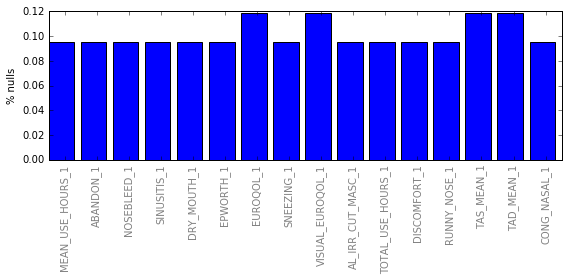

In [531]:
dfNull = np.sum(df_all[dfFeatures1.Name.values].isnull()) / float(df_all.shape[0])
dfNullAll = pd.concat([dfNull[dfNull>0],np.sum(df_all.isnull())], axis=1)
dfNullAll.columns= ["%_Null","#_Null"]

display(dfNullAll[dfNullAll.iloc[:,0].isnull() == False][["%_Null","#_Null"]])
print dfNullAll[dfNullAll.iloc[:,0].isnull() == False].shape


plt.figure(figsize=(8,4))
plt.bar(range(dfNull.shape[0]),dfNull.iloc[:])
plt.xticks(np.arange(dfNull.shape[0]) + 0.5, dfNull.index,rotation=90, alpha=0.5)
plt.ylabel("% nulls")
plt.tight_layout()
plt.show

#### Impute NaN

In [532]:
#Transform discrete
imputer = TypeFeatImputer(catCols, reducedCols)
imputer.fit(df_all.iloc[:,:-1].values.astype(float),df_all.iloc[:,-1].values.astype(float))

dfImputed = imputer.transform(df_all.iloc[:,:-1].values.astype(float))
dfImputed = pd.DataFrame(dfImputed,columns=df_all.columns[:-1])

print "Total NaN before imputation:", np.sum(np.isnan(df_all.values.astype(float)))
print "Total NaN after imputation:", np.sum(np.sum(np.isnan(dfImputed.astype(float))))
print df_all.columns[-1]
print df_all.iloc[:,-1].values

Total NaN before imputation: 76
Total NaN after imputation: 0
LABEL
[ 0.    6.5   5.    7.    5.    7.    4.    4.5   7.5   3.32  6.5   3.5
  6.51  6.5   6.    0.    8.    5.5   3.93  3.5   7.    4.99  7.5   4.    6.
  2.08  7.5   5.32  8.    7.    6.5   2.6   4.    4.5   0.97  5.5   7.    3.8
  2.12  7.5   4.    5.5 ]


#### Normality test

In [533]:
import scipy.stats as stats

arrNorm = []
for i,rv in enumerate(df_all[dfFeatures1.Name.values].columns):

    #Compute data
    cleanIc = dfImputed.loc[:,rv]    
    f_value, p_value = stats.normaltest(cleanIc)
    arrNorm.append([rv,"yes" if dfFeatures1[dfFeatures1.Name.values == rv].Type.values == "CAT" else "no", f_value.round(4), p_value.round(4), "no" if p_value < 0.05 else "yes"])
    
dfNorm = pd.DataFrame(np.array(arrNorm), columns=["variable","categoric","f_val","p_value","norm"])
print dfNorm.shape
print "Normal features:", np.sum(dfNorm["norm"] == "yes")
print "Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "no"))
print "Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "yes"))
print "No Normal features:", np.sum(dfNorm["norm"] == "no")
print "No Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "no"))
print "No Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "yes"))

dfNorm[dfNorm["categoric"] == "no"][["variable","f_val","p_value","norm"]]

(16, 5)
Normal features: 11
Normal numerical features: 6
Normal categorical features: 5
No Normal features: 5
No Normal numerical features: 1
No Normal categorical features: 4


,variable,f_val,p_value,norm
0,MEAN_USE_HOURS_1,6.1217,0.0468,no
5,EPWORTH_1,3.7226,0.1555,yes
6,EUROQOL_1,1.8279,0.4009,yes
8,VISUAL_EUROQOL_1,5.4987,0.064,yes
10,TOTAL_USE_HOURS_1,2.8745,0.2376,yes
13,TAS_MEAN_1,2.9091,0.2335,yes
14,TAD_MEAN_1,3.8031,0.1493,yes


#### Distribution Numeric features

In [534]:
df_all.loc[:,"EUROQOL_1"].values.astype(float)

array([     nan,  0.7986 ,  0.73901,  0.7601 ,  1.     ,  1.     ,
        1.     ,  1.     ,  0.7986 ,  1.     ,  1.     ,  0.7005 ,
        1.     ,  1.     ,  1.     ,  1.     ,  0.7902 ,  1.     ,
        0.7601 ,  0.7601 ,  0.7986 ,  0.7986 ,      nan,  1.     ,
        0.7902 ,      nan,  1.     ,  0.7986 ,  0.493  ,  0.7986 ,
            nan,  0.7986 ,  0.7902 ,  0.7902 ,  1.     ,  0.7005 ,
        0.5442 ,  0.74301,  1.     ,  0.5942 ,      nan,  0.7902 ])

MEAN_USE_HOURS_1
Unique values: 17
p-value: 0.0468479390193
Normal: False
Mean: 5.43947368421 std: 1.63263437042


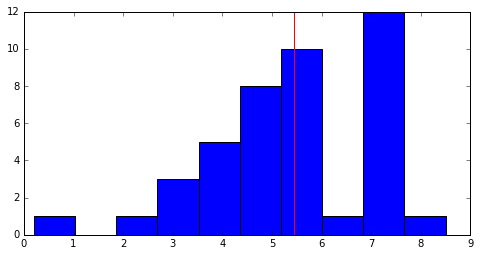

EPWORTH_1
Unique values: 18
p-value: 0.155472940551
Normal: True
Mean: 6.06842105263 std: 3.47810192238


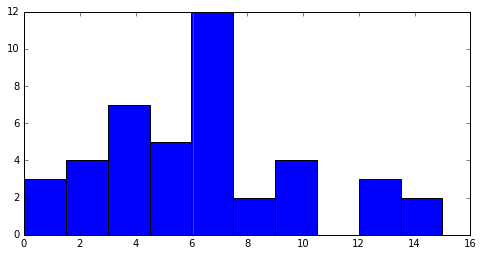

EUROQOL_1
Unique values: 11
p-value: 0.4009412183
Normal: True
Mean: 0.846916756757 std: 0.133864771301


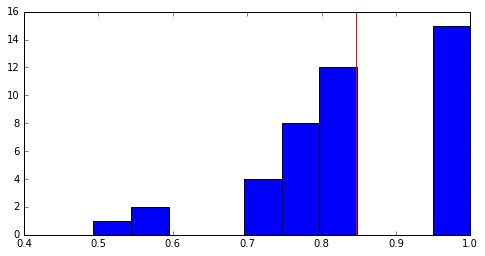

VISUAL_EUROQOL_1
Unique values: 10
p-value: 0.0639696981121
Normal: True
Mean: 70.9459459459 std: 16.7558745149


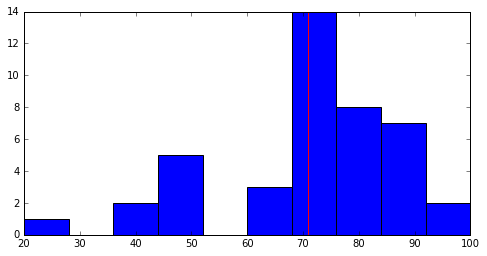

TOTAL_USE_HOURS_1
Unique values: 37
p-value: 0.237584449451
Normal: True
Mean: 217.684210526 std: 94.4291382752


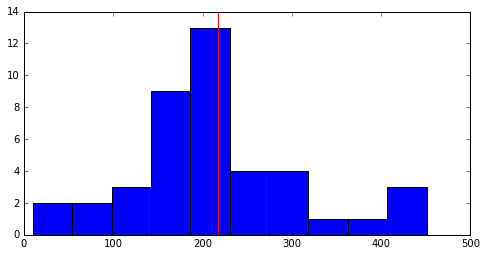

TAS_MEAN_1
Unique values: 36
p-value: 0.233503191802
Normal: True
Mean: 133.040540541 std: 17.9954949317


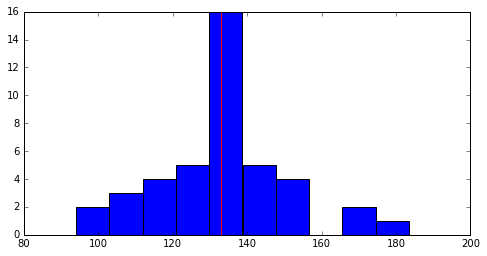

TAD_MEAN_1
Unique values: 25
p-value: 0.149335034477
Normal: True
Mean: 82.4459459459 std: 11.6085886635


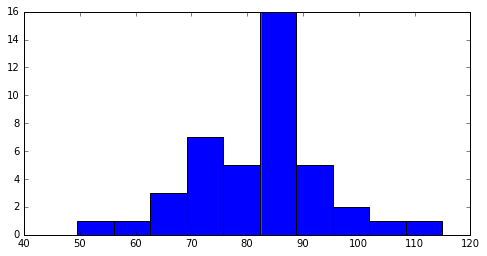

In [535]:
from scipy.stats import boxcox

for i,rv in enumerate(df_all[dfFeatures1.Name.values].columns):

    #Compute data
    cleanIc = dfImputed.loc[:,rv]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "no":

        f_value, p_value = stats.normaltest(cleanIc)
    
        print rv
        print "Unique values:", len(np.unique(cleanIc))
        print "p-value:", p_value 
        print "Normal:", p_value >= 0.05
        print "Mean:", np.mean(cleanIc), "std:", np.std(cleanIc)
        
        plt.figure(figsize=(8,4))
        plt.hist(cleanIc, bins=10)
        plt.axvline(np.mean(cleanIc), c="r")
        plt.show()        

#### Distribution categorical features

ABANDON_1
0.00    42
Name: ABANDON_1, dtype: int64


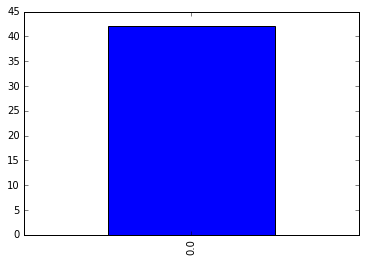

NOSEBLEED_1
0.00    42
Name: NOSEBLEED_1, dtype: int64


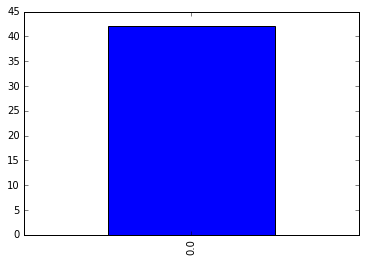

SINUSITIS_1
0.00    42
Name: SINUSITIS_1, dtype: int64


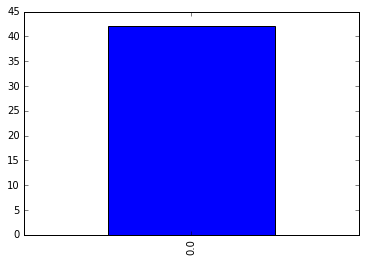

DRY_MOUTH_1
0.00    24
1.00    18
Name: DRY_MOUTH_1, dtype: int64


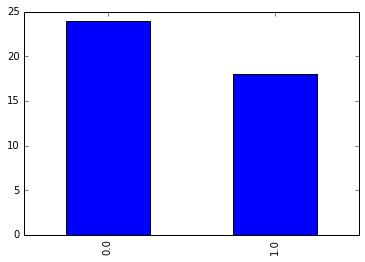

SNEEZING_1
0.00    41
1.00    1 
Name: SNEEZING_1, dtype: int64


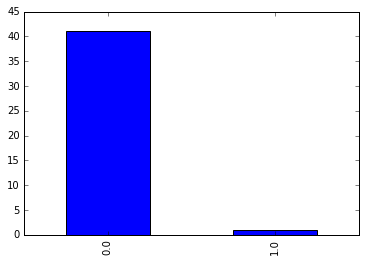

AL_IRR_CUT_MASC_1
0.00    34
1.00    8 
Name: AL_IRR_CUT_MASC_1, dtype: int64


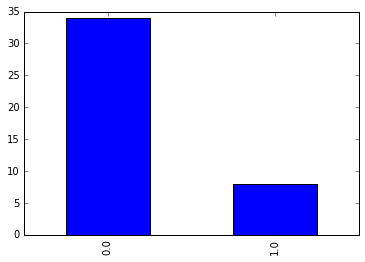

DISCOMFORT_1
0.00    42
Name: DISCOMFORT_1, dtype: int64


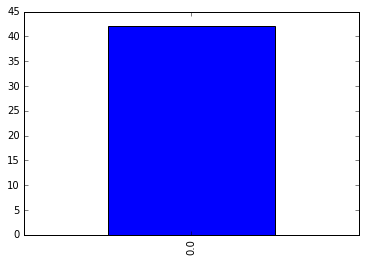

RUNNY_NOSE_1
0.00    41
1.00    1 
Name: RUNNY_NOSE_1, dtype: int64


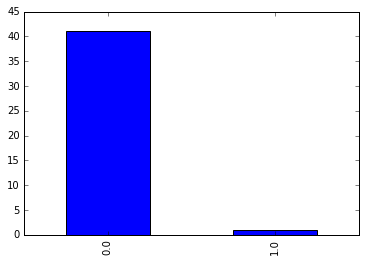

CONG_NASAL_1
0.00    41
1.00    1 
Name: CONG_NASAL_1, dtype: int64


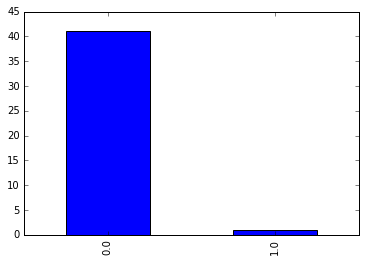

In [536]:
for i,rv in enumerate(df_all[dfFeatures1.Name.values].columns):
    
    #Compute data
    cleanIc = dfImputed.loc[:,rv]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "yes":                
        print rv
        print pd.value_counts(cleanIc)                
        pd.value_counts(cleanIc).plot(kind="bar")
        plt.show()

#### Irrelevant categorical features
(Few instances in a category)

In [537]:
minConts = []
for i,rv in enumerate(df_all[dfFeatures1.Name.values].columns):

    #Compute data
    cleanIc = dfImputed.loc[:,rv]
    
    if dfFeatures1[dfFeatures1.Name == rv][dfFeatures1.Type == "CAT"].shape[0] > 0:                
        minConts.append([rv,
                         pd.value_counts(cleanIc).index.tolist(), 
                         pd.value_counts(cleanIc).values.tolist(),
                         (pd.value_counts(cleanIc).values/float(np.sum(pd.value_counts(cleanIc).values))).round(2).tolist(),
                         pd.value_counts(cleanIc).values.min(),
                         pd.value_counts(cleanIc).values.max()
                        ])    
dfCatSum = pd.DataFrame(minConts, columns=["variable","categories","frequencies","ratios","min","max"])

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [538]:
to_del = dfFeatures.ix[["ABANDONO_1", "CONG_NASAL_1", "SECR_NASAL_1","ESTORNUDOS_1","SINUSITIS_1",
         "HEMO_NASAL_1","MALESTAR_1"]].Name.tolist()


display(HTML(dfCatSum[dfCatSum["variable"].isin(to_del)][["variable","categories","frequencies","ratios"]].to_html(index=False)))
print dfCatSum[dfCatSum["variable"].isin(to_del)].shape
print len(to_del)

variable,categories,frequencies,ratios
ABANDON_1,[0.0],[42],[1.0]
NOSEBLEED_1,[0.0],[42],[1.0]
SINUSITIS_1,[0.0],[42],[1.0]
SNEEZING_1,"[0.0, 1.0]","[41, 1]","[0.98, 0.02]"
DISCOMFORT_1,[0.0],[42],[1.0]
RUNNY_NOSE_1,"[0.0, 1.0]","[41, 1]","[0.98, 0.02]"
CONG_NASAL_1,"[0.0, 1.0]","[41, 1]","[0.98, 0.02]"


(7, 6)
7


#### Correlated numerical features

In [539]:
dfImputedLabel = pd.concat([dfImputed,df_all.iloc[:,-1]], axis=1)
print dfImputedLabel.shape

(42, 71)


In [540]:
#Correlations

relVars = df_all.columns[:-1][catCols==0]
relVars = [c for c in relVars.values if c not in to_del]

dataCor = []
for item in (relVars):
    for col in (relVars):

        cv1 = dfImputed[item].values
        cv2 = dfImputed[col].values
        
        #Spearman corr better for categorical features
        c_sp,p_sp = stats.spearmanr(cv1,cv2,nan_policy="raise")
        
        #Pearson corr, classical
        cv1_norm = np.log(cv1 + 1)#preprocessing.normalize(cv1.reshape(-1, 1))
        cv2_norm = np.log(cv2 + 1)#preprocessing.normalize(cv2.reshape(-1, 1))
        c_pr,p_pr = stats.pearsonr(cv1_norm,cv2_norm)
        
        #Normalized mutual info for non normal data
        c_mi = normalized_mutual_info_score(cv1, cv2)
        p_mi = -1
        
        sc1, pval1 = stats.mannwhitneyu(cv1.reshape(-1,1),df_all.iloc[:,-1].values.reshape(-1,1))
        sc2, pval2 = stats.mannwhitneyu(cv2.reshape(-1,1),df_all.iloc[:,-1].reshape(-1,1))
                
        
        dataCor.append([item,col,c_sp,p_sp,c_pr,p_pr,c_mi,p_mi, pval1, pval2])

dataCor = np.array(dataCor)
dfCorr = pd.DataFrame(dataCor,columns=["cov1","cov2","c_sp","p_sp","c_pr","p_pr","c_mi","p_mi","pval_cv1","pval_cv2"])
dfCorr["c_sp"] = dfCorr["c_sp"].astype(float)
dfCorr["c_pr"] = dfCorr["c_pr"].astype(float)
dfCorr["c_mi"] = dfCorr["c_mi"].astype(float)
dfCorr["pval_cv1"] = dfCorr["pval_cv1"].astype(float)
dfCorr["pval_cv2"] = dfCorr["pval_cv2"].astype(float)

print dfCorr.shape

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


(676, 10)


In [541]:
pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfCorr[np.logical_and(dfCorr["c_sp"] >= 0.8, dfCorr["cov1"] != dfCorr["cov2"])][["cov1","cov2","c_sp"]].to_html(index=False)))

cov1,cov2,c_sp


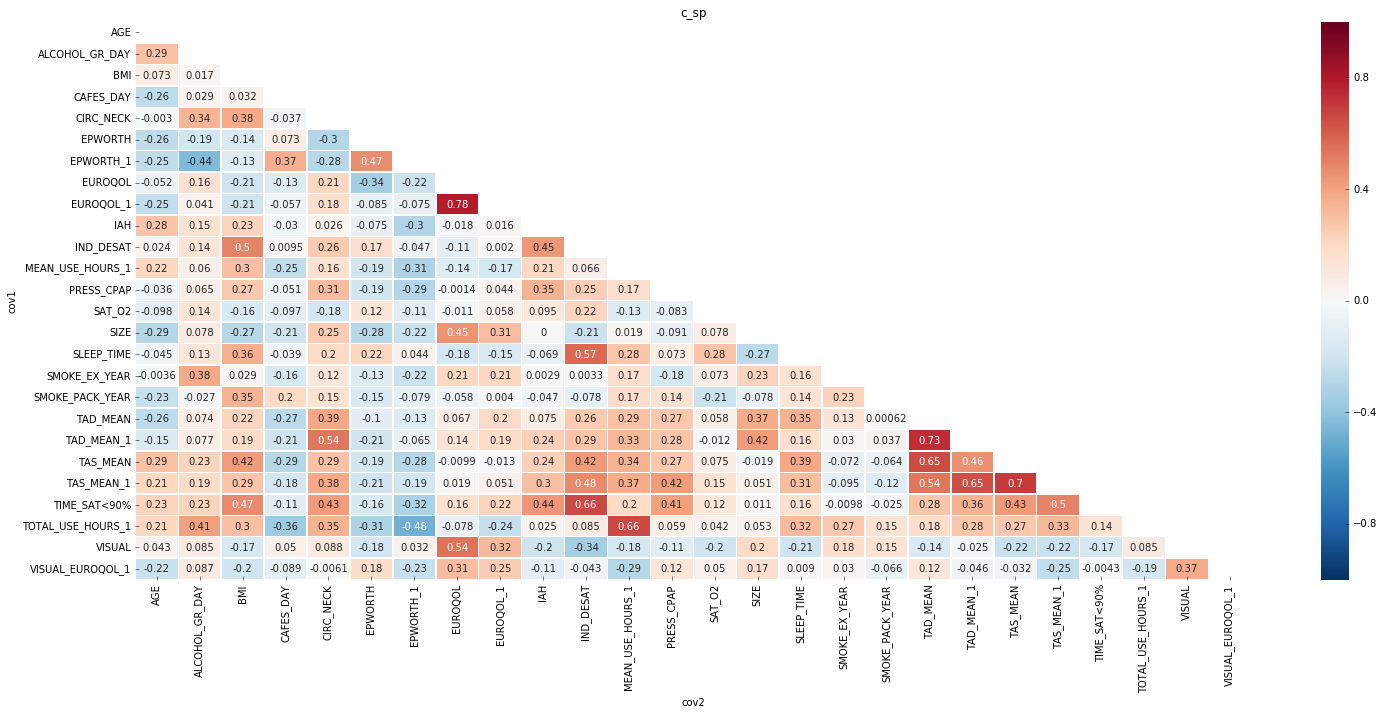

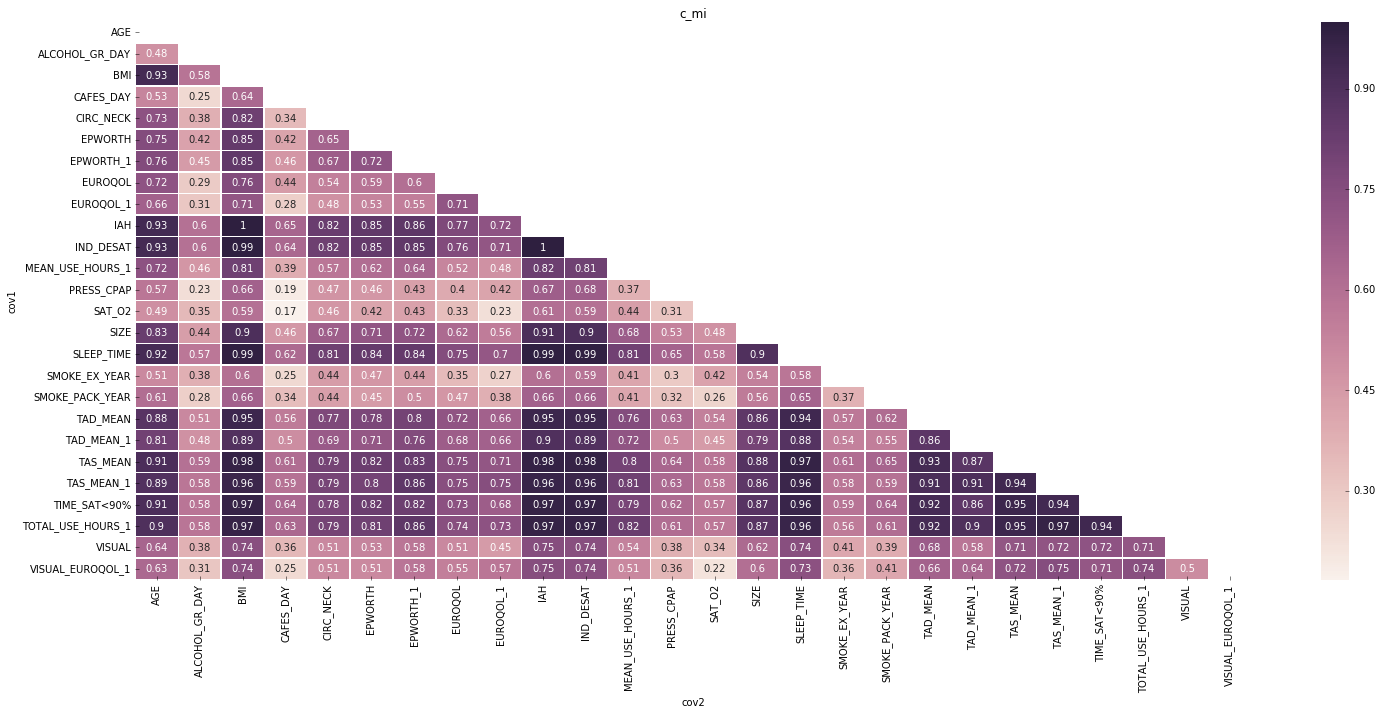

In [542]:
for c in ["c_sp","c_mi"]: #,"c_mi"
    pvt = dfCorr.pivot_table(index="cov1",columns="cov2", values=c)
    pvt

    # Generate a mask for the upper triangle
    mask = np.zeros_like(pvt, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    #Plot
    plt.figure(figsize=(25,10))
    plt.yticks(rotation=90)
    plt.xticks(rotation=90)
    sns.heatmap(pvt.iloc[:,:], annot=True, linewidths=.5, mask=mask, fmt=".2g")
    
    plt.title(c)

Numerical features to remove

In [543]:
to_del.extend([])

#### Correlations on categorical features

In [544]:
#Correlations

relVars = df_all.columns[:-1][catCols==1]
relVars = [c for c in relVars.values if c not in to_del]
dataCor = []
for item in (relVars):
    for col in (relVars):

        cv1 = dfImputed[item].values
        cv2 = dfImputed[col].values

        #Spearman corr better for categorical features
        c_sp,p_sp = stats.spearmanr(cv1,cv2,nan_policy="raise")

        #Pearson corr, classical
        c_pr,p_pr = stats.pearsonr(cv1,cv2)

        #Normalized mutual info for non normal data
        c_mi = normalized_mutual_info_score(cv1, cv2)
        p_mi = -1
        dataCor.append([item,col,c_sp,p_sp,c_pr,p_pr,c_mi,p_mi])

dataCor = np.array(dataCor)
dfCorr = pd.DataFrame(dataCor,columns=["cov1","cov2","c_sp","p_sp","c_pr","p_pr","c_mi","p_mi"])
dfCorr["c_sp"] = dfCorr["c_sp"].astype(float)
dfCorr["c_pr"] = dfCorr["c_pr"].astype(float)
dfCorr["c_mi"] = dfCorr["c_mi"].astype(float)
print dfCorr.shape

(1369, 8)


In [545]:
pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfCorr[np.logical_and(dfCorr["c_mi"] >= 0.5, dfCorr["cov1"] != dfCorr["cov2"])][["cov1","cov2","c_mi"]].to_html(index=False)))

cov1,cov2,c_mi
ACTIVE,RETIRED,0.683
RETIRED,ACTIVE,0.683


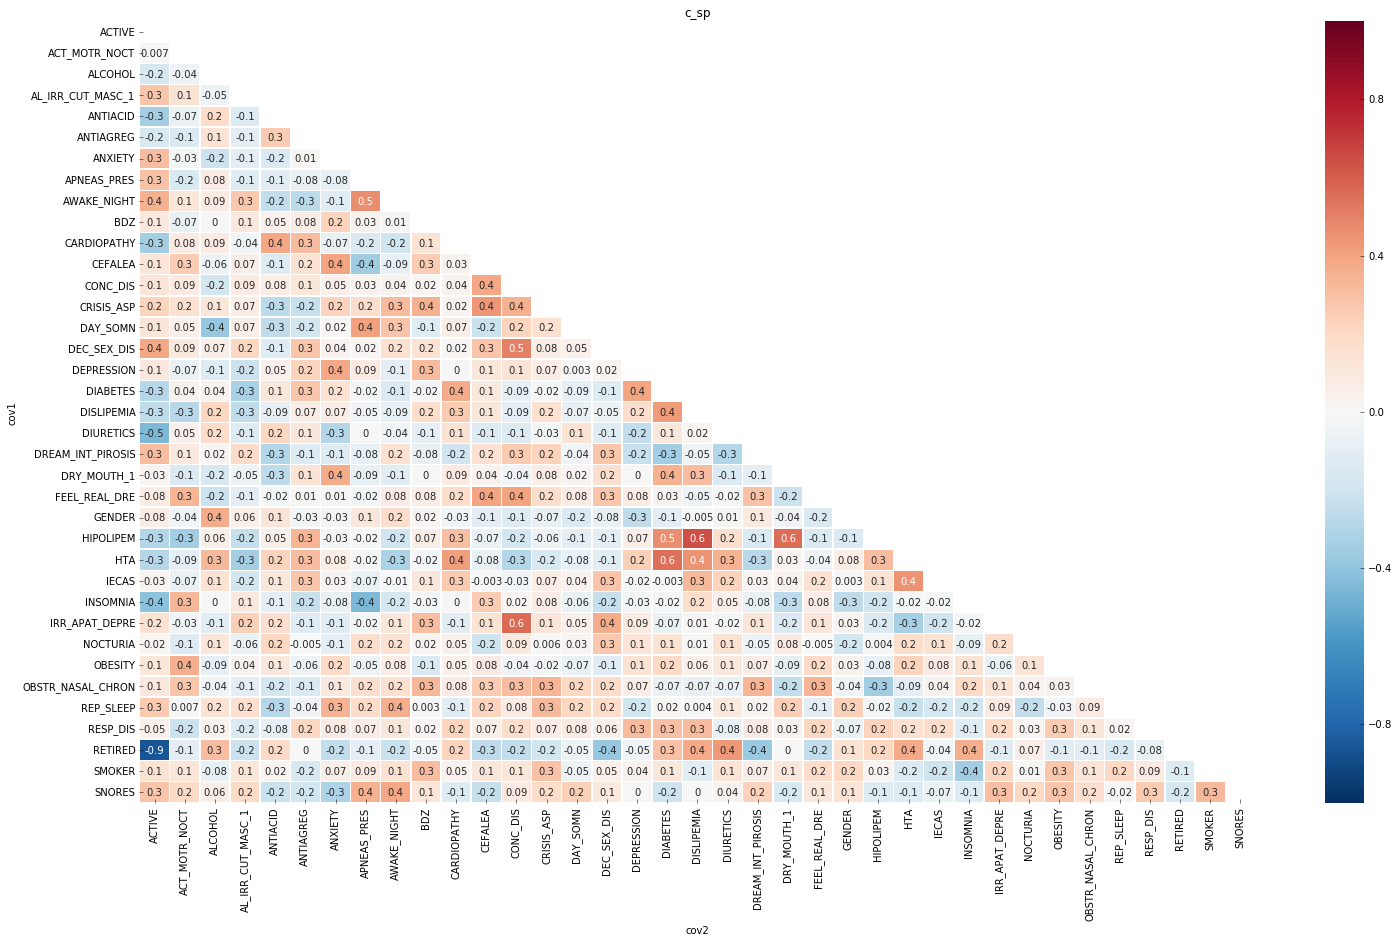

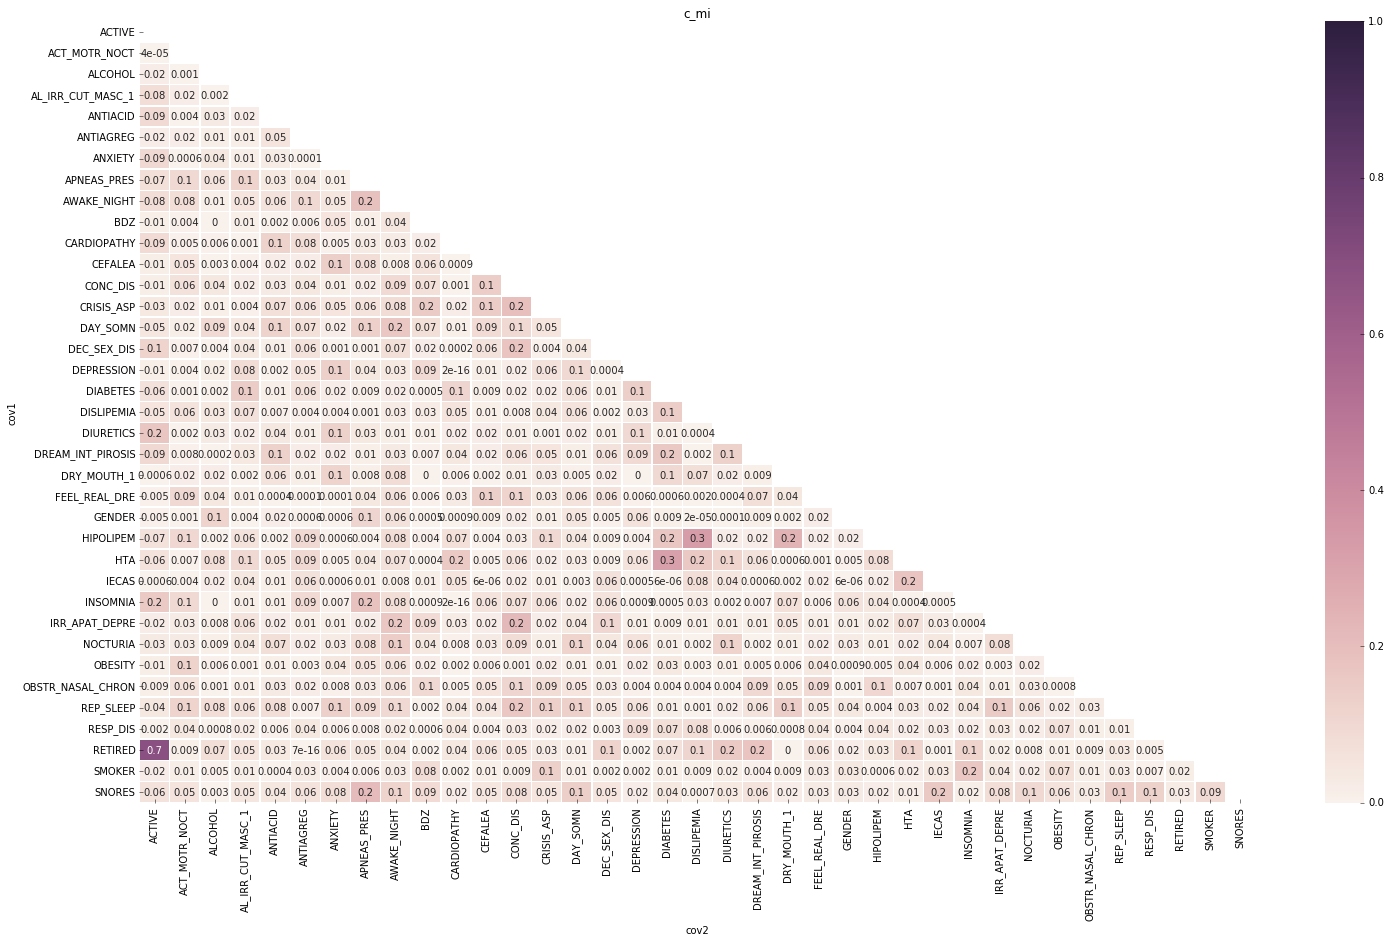

In [546]:
for c in ["c_sp","c_mi"]: #,"c_mi"
    pvt = dfCorr.pivot_table(index="cov1",columns="cov2", values=c)
    pvt

    # Generate a mask for the upper triangle
    mask = np.zeros_like(pvt, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    #Plot
    plt.figure(figsize=(25,14))
    plt.yticks(rotation=90)
    plt.xticks(rotation=90)
    sns.heatmap(pvt.iloc[:,:], annot=True, linewidths=.5, mask=mask, fmt=".1g")
    
    plt.title(c)

Categorical features to remove

In [547]:
to_del.extend([])

#### Significance test feature vs class

In [548]:
thrs = [3.5, 3.9, 4.0, 4.2, 4.5, 5.0]
thr = thrs[-4]
print "Selected threshold:",  thr

Selected threshold: 4.0


In [549]:
#dfImputed = pd.DataFrame(dfImputed, columns=reducedCols)
dfImputed["LABEL"] = df_all["LABEL"]

dfImputed["LABEL"][dfImputed["LABEL"] <= thr] = 0
dfImputed["LABEL"][dfImputed["LABEL"] > thr] = 1
dfImputed["LABEL"] = dfImputed["LABEL"].astype(int)

print pd.value_counts(dfImputed["LABEL"])

1    27
0    15
Name: LABEL, dtype: int64


[0.0, 0.0, 0.97, 2.08, 2.12, 2.6, 3.32, 3.5, 3.5, 3.8, 3.93, 4.0, 4.0, 4.0, 4.0, 4.5, 4.5, 4.99, 5.0, 5.0, 5.32, 5.5, 5.5, 5.5, 6.0, 6.0, 6.5, 6.5, 6.5, 6.5, 6.51, 7.0, 7.0, 7.0, 7.0, 7.0, 7.5, 7.5, 7.5, 7.5, 8.0, 8.0]


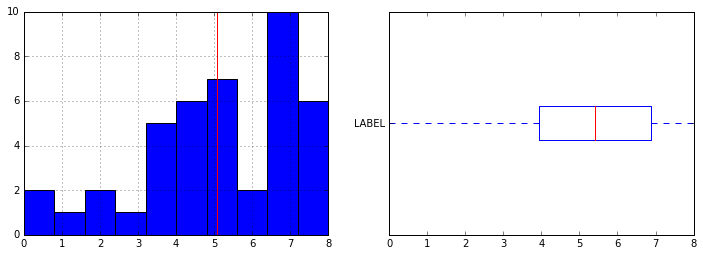

count   42.000
mean    5.075 
std     2.096 
min     0.000 
25%     3.948 
50%     5.410 
75%     6.877 
max     8.000 
Name: LABEL, dtype: float64

In [550]:
# Compute label column
lblCol = df_all["LABEL"]
lblCol = pd.to_numeric(lblCol)

plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
print lblCol.sort_values().tolist()
lblCol.hist(ax = ax)
ax.axvline(lblCol.mean(), c="r")
ax = plt.subplot(1,2,2)
lblCol.plot(kind="box", ax=ax, rot=0, vert=False)
plt.show()
lblCol.describe()

#### Categorical features vs label (proportions)

In [551]:
import pandas as pd
import scipy.stats as scs


def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]

    return scs.chi2_contingency(result)

In [552]:
sigArr = []

GENDER
   LABEL  GENDER  count  perc
0  0     0.000    5     0.333
1  0     1.000    10    0.667
2  1     0.000    8     0.296
3  1     1.000    19    0.704
0.00990274093722 0.92073135051 ['no']
[ 0.01915709] [ 0.88991708] ['no']


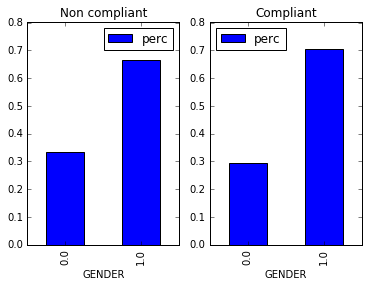

ACTIVE
   LABEL  ACTIVE  count  perc
0  0     0.000    7     0.467
1  0     1.000    8     0.533
2  1     0.000    10    0.370
3  1     1.000    17    0.630
0.0790588235294 0.77857693838 ['no']
[ 0.15022222] [ 0.69832309] ['no']


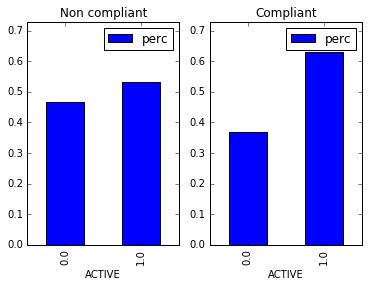

RETIRED
   LABEL  RETIRED  count  perc
0  0     0.000     9     0.600
1  0     1.000     6     0.400
2  1     0.000     19    0.704
3  1     1.000     8     0.296
0.116666666667 0.732678261376 ['no']
[ 0.31111111] [ 0.57699916] ['no']


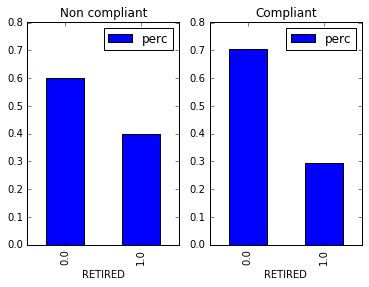

SMOKER
   LABEL  SMOKER  count  perc
0  0     0.000    9     0.600
1  0     1.000    6     0.400
2  1     0.000    17    0.630
3  1     1.000    10    0.370
0.0201923076923 0.887001302518 ['no']
[ 0.02222222] [ 0.88149745] ['no']


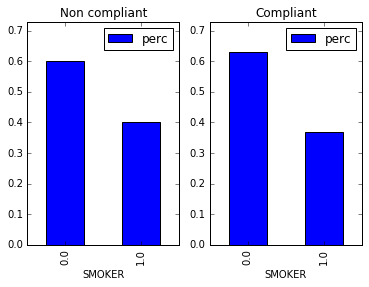

ALCOHOL
   LABEL  ALCOHOL  count  perc
0  0     0.000     10    0.667
1  0     1.000     5     0.333
2  1     0.000     14    0.519
3  1     1.000     13    0.481
0.36512345679 0.545674475979 ['no']
[ 0.49382716] [ 0.48222504] ['no']


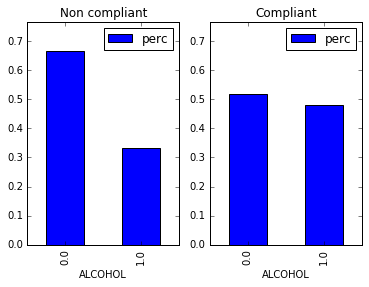

DEPRESSION
   LABEL  DEPRESSION  count  perc
0  0     0.000        14    0.933
1  0     1.000        1     0.067
2  1     0.000        21    0.778
3  1     1.000        6     0.222
0.746666666667 0.387533640255 ['no']
[ 1.4] [ 0.23672357] ['no']


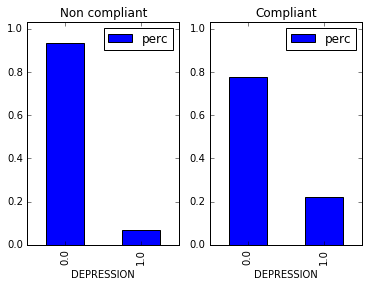

ANXIETY
   LABEL  ANXIETY  count  perc
0  0     0.000     11    0.733
1  0     1.000     4     0.267
2  1     0.000     22    0.815
3  1     1.000     5     0.185
0.0502805836139 0.822575754748 ['no']
[ 0.29876543] [ 0.58465742] ['no']


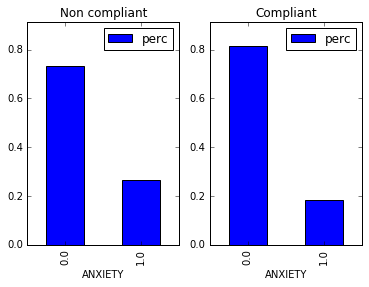

HTA
   LABEL   HTA  count  perc
0  0     0.000  10    0.667
1  0     1.000  5     0.333
2  1     0.000  7     0.259
3  1     1.000  20    0.741
5.05976470588 0.024487562385 ['yes']
[ 2.68888889] [ 0.10105026] ['no']


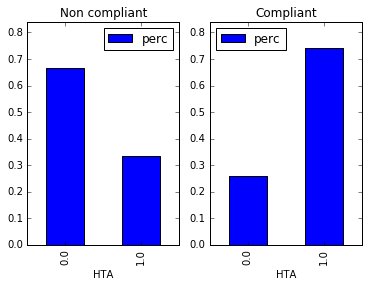

CARDIOPATHY
   LABEL  CARDIOPATHY  count  perc
0  0     0.000         12    0.800
1  0     1.000         3     0.200
2  1     0.000         18    0.667
3  1     1.000         9     0.333
0.313703703704 0.575416287928 ['no']
[ 0.6] [ 0.43857803] ['no']


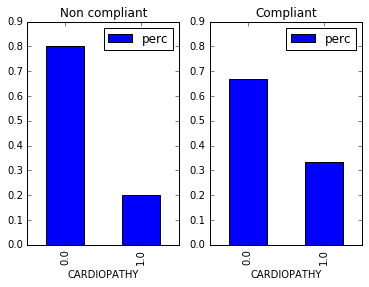

RESP_DIS
   LABEL  RESP_DIS  count  perc
0  0     0.000      12    0.800
1  0     1.000      3     0.200
2  1     0.000      19    0.704
3  1     1.000      8     0.296
0.0985337243402 0.753596368123 ['no']
[ 0.34141414] [ 0.55901409] ['no']


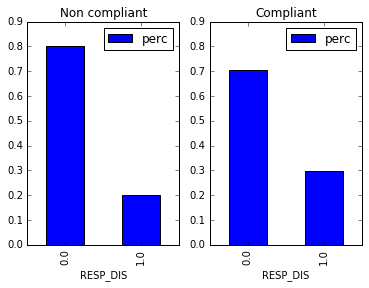

DIABETES
   LABEL  DIABETES  count  perc
0  0     0.000      11    0.733
1  0     1.000      4     0.267
2  1     0.000      18    0.667
3  1     1.000      9     0.333
0.00990274093722 0.92073135051 ['no']
[ 0.13846154] [ 0.70981527] ['no']


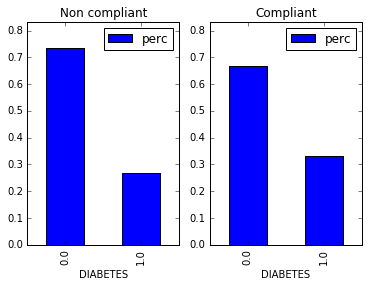

OBESITY
   LABEL  OBESITY  count  perc
0  0     0.000     6     0.400
1  0     1.000     9     0.600
2  1     0.000     6     0.222
3  1     1.000     21    0.778
0.749259259259 0.386710855045 ['no']
[ 0.42666667] [ 0.51362911] ['no']


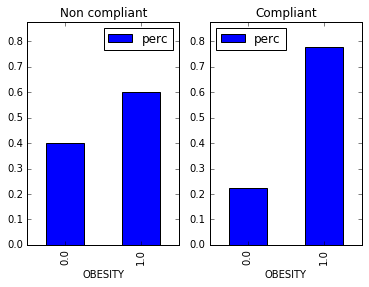

DISLIPEMIA
   LABEL  DISLIPEMIA  count  perc
0  0     0.000        8     0.533
1  0     1.000        7     0.467
2  1     0.000        18    0.667
3  1     1.000        9     0.333
0.271474358974 0.602344470315 ['no']
[ 0.45] [ 0.50233495] ['no']


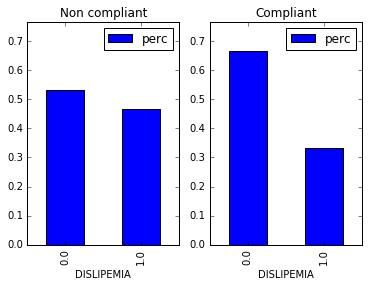

OBSTR_NASAL_CHRON
   LABEL  OBSTR_NASAL_CHRON  count  perc
0  0     0.000               8     0.533
1  0     1.000               7     0.467
2  1     0.000               19    0.704
3  1     1.000               8     0.296
0.589958847737 0.442435032483 ['no']
[ 0.7837037] [ 0.3760108] ['no']


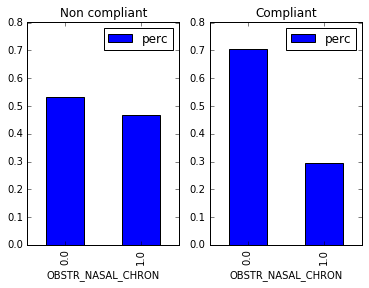

SNORES
   LABEL  SNORES  count  perc
0  0     1.000    1     0.067
1  0     2.000    5     0.333
2  0     3.000    9     0.600
3  1     1.000    2     0.074
4  1     2.000    5     0.185
5  1     3.000    20    0.741
1.17292464879 0.556291787686 ['no']
[ 0.06545455] [ 0.79807372] ['no']


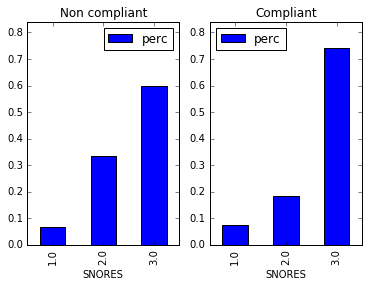

REP_SLEEP
   LABEL  REP_SLEEP  count  perc
0  0     0.000       3     0.200
1  0     1.000       2     0.133
2  0     2.000       8     0.533
3  0     3.000       2     0.133
4  1     0.000       8     0.296
5  1     1.000       5     0.185
6  1     2.000       11    0.407
7  1     3.000       3     0.111
0.874981392876 0.831460787804 ['no']
[ 0.48] [ 0.48842232] ['no']


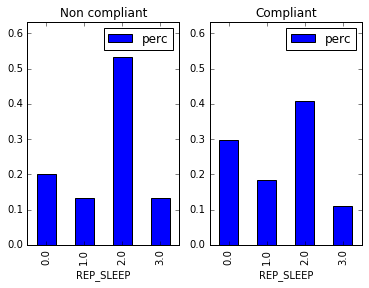

CRISIS_ASP
   LABEL  CRISIS_ASP  count  perc
0  0     0.000        6     0.400
1  0     1.000        7     0.467
2  0     2.000        2     0.133
3  1     0.000        18    0.667
4  1     1.000        7     0.259
5  1     2.000        2     0.074
2.8 0.246596963942 ['no']
[ 1.95555556] [ 0.16198944] ['no']


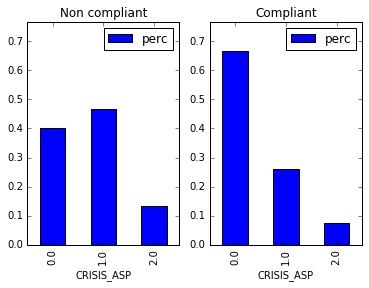

NOCTURIA
   LABEL  NOCTURIA  count  perc
0  0     0.000      4     0.267
1  0     1.000      5     0.333
2  0     2.000      1     0.067
3  0     3.000      5     0.333
4  1     0.000      5     0.185
5  1     1.000      7     0.259
6  1     2.000      4     0.148
7  1     3.000      11    0.407
1.16061728395 0.762464566771 ['no']
[ 0.56] [ 0.45426024] ['no']


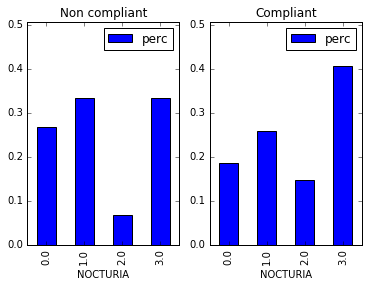

APNEAS_PRES
   LABEL  APNEAS_PRES  count  perc
0  0     0.000         4     0.267
1  0     1.000         5     0.333
2  0     2.000         4     0.267
3  0     3.000         2     0.133
4  1     0.000         6     0.222
5  1     1.000         5     0.185
6  1     2.000         9     0.333
7  1     3.000         7     0.259
1.82093067426 0.610390813319 ['no']
[ 0.84691358] [ 0.35742694] ['no']


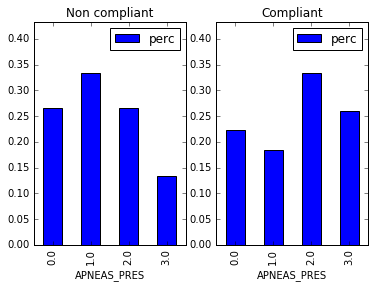

CEFALEA
   LABEL  CEFALEA  count  perc
0  0     0.000     6     0.400
1  0     1.000     9     0.600
2  1     0.000     23    0.852
3  1     1.000     4     0.148
7.21909814324 0.00721319392413 ['yes']
[ 6.36068376] [ 0.01166766] ['yes']


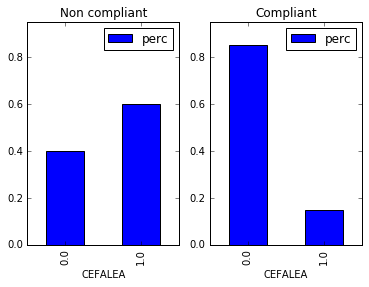

DAY_SOMN
   LABEL  DAY_SOMN  count  perc
0  0     0.000      4     0.267
1  0     1.000      6     0.400
2  0     2.000      3     0.200
3  0     3.000      2     0.133
4  1     0.000      9     0.333
5  1     1.000      5     0.185
6  1     2.000      7     0.259
7  1     3.000      6     0.222
2.37967365967 0.497429579955 ['no']
[ 0.21373737] [ 0.64385373] ['no']


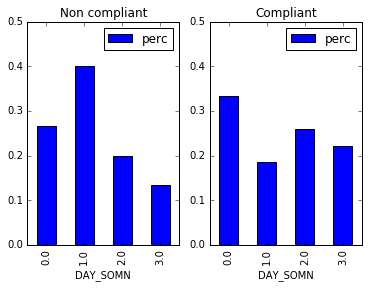

AWAKE_NIGHT
   LABEL  AWAKE_NIGHT  count  perc
0  0     0.000         7     0.467
1  0     1.000         3     0.200
2  0     2.000         4     0.267
3  0     3.000         1     0.067
4  1     0.000         14    0.519
5  1     1.000         2     0.074
6  1     2.000         7     0.259
7  1     3.000         4     0.148
1.87609427609 0.598517570976 ['no']
[ 0.1037037] [ 0.74742952] ['no']


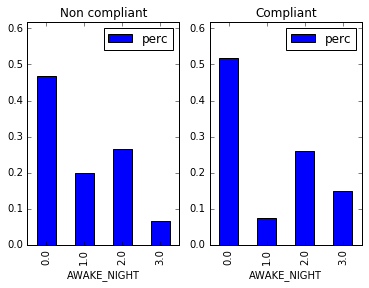

CONC_DIS
   LABEL  CONC_DIS  count  perc
0  0     0.000      9     0.600
1  0     1.000      1     0.067
2  0     2.000      5     0.333
3  1     0.000      20    0.741
4  1     1.000      6     0.222
5  1     2.000      1     0.037
7.60255427842 0.0223422195029 ['yes']
[ 4.07134503] [ 0.04361653] ['yes']


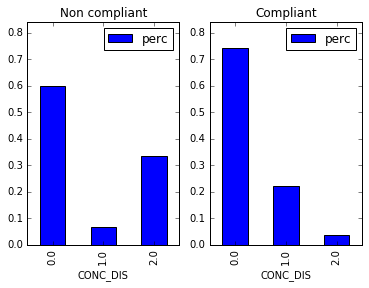

IRR_APAT_DEPRE
   LABEL  IRR_APAT_DEPRE  count  perc
0  0     0.000            5     0.333
1  0     1.000            6     0.400
2  0     2.000            4     0.267
3  1     0.000            18    0.667
4  1     1.000            7     0.259
5  1     2.000            2     0.074
5.07731945993 0.0789721729296 ['no']
[ 4.48088889] [ 0.03427589] ['yes']


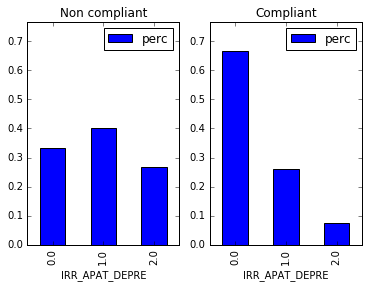

INSOMNIA
   LABEL  INSOMNIA  count  perc
0  0     0.000      10    0.667
1  0     1.000      5     0.333
2  1     0.000      25    0.926
3  1     1.000      2     0.074
2.98666666667 0.0839528182931 ['no']
[ 3.88888889] [ 0.04860657] ['yes']


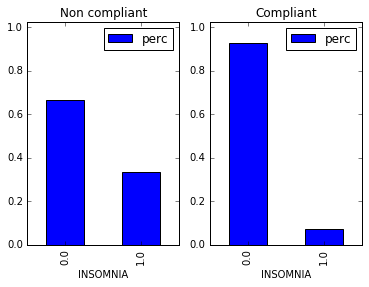

ACT_MOTR_NOCT
   LABEL  ACT_MOTR_NOCT  count  perc
0  0     0.000           9     0.600
1  0     1.000           6     0.400
2  1     0.000           18    0.667
3  1     1.000           9     0.333
0.00921810699588 0.923511857386 ['no']
[ 0.12] [ 0.72903449] ['no']


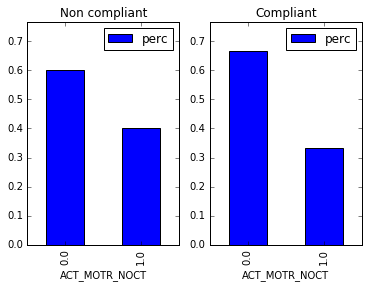

FEEL_REAL_DRE
   LABEL  FEEL_REAL_DRE  count  perc
0  0     0.000           11    0.733
1  0     1.000           4     0.267
2  1     0.000           22    0.815
3  1     1.000           5     0.185
0.0502805836139 0.822575754748 ['no']
[ 0.29876543] [ 0.58465742] ['no']


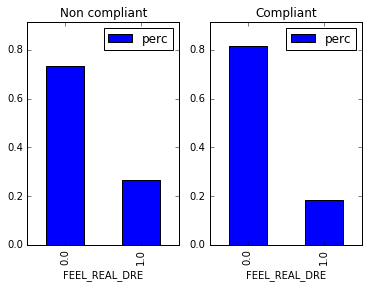

DREAM_INT_PIROSIS
   LABEL  DREAM_INT_PIROSIS  count  perc
0  0     0.000               12    0.800
1  0     1.000               3     0.200
2  1     0.000               21    0.778
3  1     1.000               6     0.222
0.0502805836139 0.822575754748 ['no']
[ 0.02222222] [ 0.88149745] ['no']


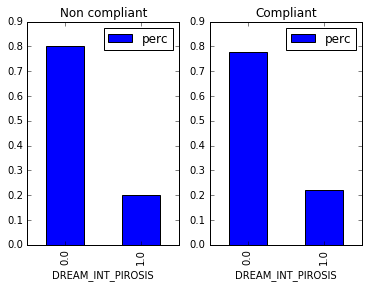

DEC_SEX_DIS
   LABEL  DEC_SEX_DIS  count  perc
0  0     0.000         9     0.600
1  0     1.000         6     0.400
2  1     0.000         16    0.593
3  1     1.000         11    0.407
0.0790588235294 0.77857693838 ['no']
[ 0.00130719] [ 0.97115871] ['no']


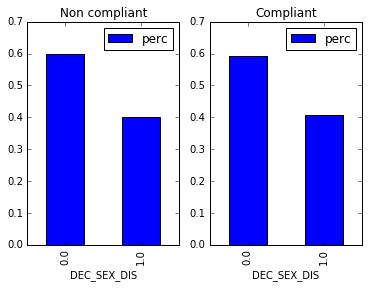

IECAS
   LABEL  IECAS  count  perc
0  0     0.000   13    0.867
1  0     1.000   2     0.133
2  1     0.000   16    0.593
3  1     1.000   11    0.407
2.22811671088 0.135518942157 ['no']
[ 2.34017094] [ 0.12607572] ['no']


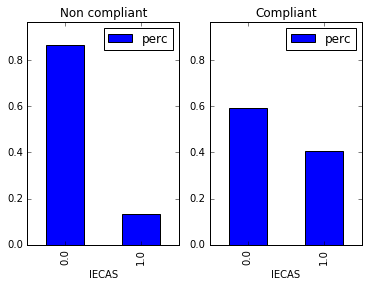

DIURETICS
   LABEL  DIURETICS  count  perc
0  0     0.000       13    0.867
1  0     1.000       2     0.133
2  1     0.000       19    0.704
3  1     1.000       8     0.296
0.65625 0.417886964318 ['no']
[ 1.07555556] [ 0.29969394] ['no']


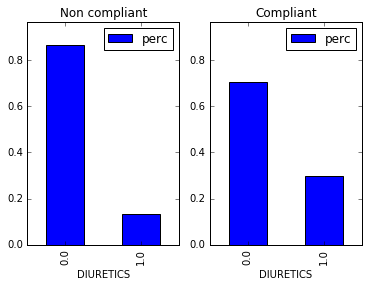

ANTIAGREG
   LABEL  ANTIAGREG  count  perc
0  0     0.000       15    1.000
1  1     0.000       18    0.667
2  1     1.000       9     0.333
4.53782267116 0.0331537369765 ['yes']
[ 5.] [ 0.02534732] ['yes']


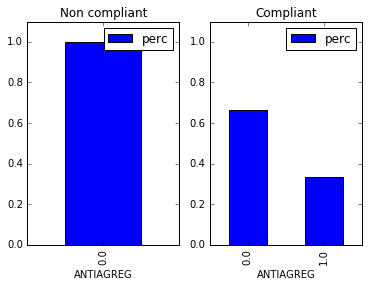

ANTIACID
   LABEL  ANTIACID  count  perc
0  0     0.000      12    0.800
1  0     1.000      3     0.200
2  1     0.000      20    0.741
3  1     1.000      7     0.259
0.00291666666667 0.956930246487 ['no']
[ 0.14222222] [ 0.70608174] ['no']


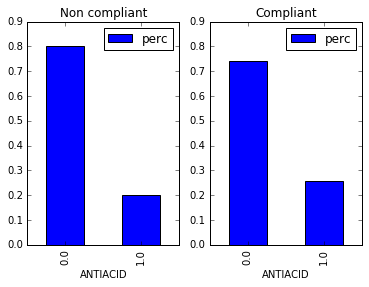

HIPOLIPEM
   LABEL  HIPOLIPEM  count  perc
0  0     0.000       10    0.667
1  0     1.000       5     0.333
2  1     0.000       17    0.630
3  1     1.000       10    0.370
0.00921810699588 0.923511857386 ['no']
[ 0.03703704] [ 0.84738966] ['no']


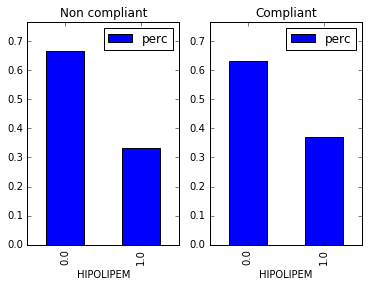

BDZ
   LABEL   BDZ  count  perc
0  0     0.000  11    0.733
1  0     1.000  4     0.267
2  1     0.000  24    0.889
3  1     1.000  3     0.111
0.746666666667 0.387533640255 ['no']
[ 1.4] [ 0.23672357] ['no']


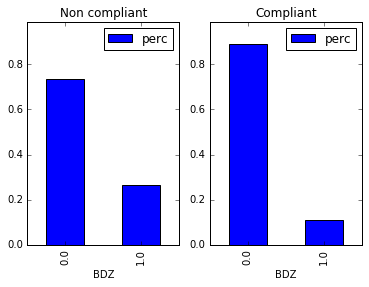

ABANDON_1
   LABEL  ABANDON_1  count  perc
0  0     0.000       15    1.000
1  1     0.000       27    1.000
0.0 1.0 ['no']
[ nan] [ nan] ['no']


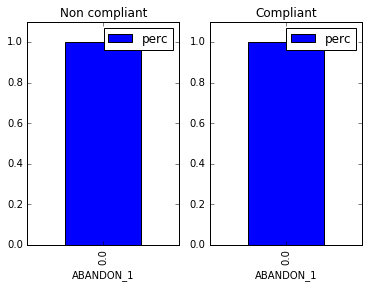

AL_IRR_CUT_MASC_1
   LABEL  AL_IRR_CUT_MASC_1  count  perc
0  0     0.000               11    0.733
1  0     1.000               4     0.267
2  1     0.000               23    0.852
3  1     1.000               4     0.148
0.277941176471 0.598053828561 ['no']
[ 0.71111111] [ 0.3990752] ['no']


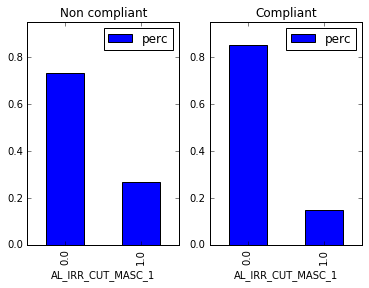

DRY_MOUTH_1
   LABEL  DRY_MOUTH_1  count  perc
0  0     0.000         7     0.467
1  0     1.000         8     0.533
2  1     0.000         17    0.630
3  1     1.000         10    0.370
0.486111111111 0.485667196335 ['no']
[ 0.59753086] [ 0.43952167] ['no']


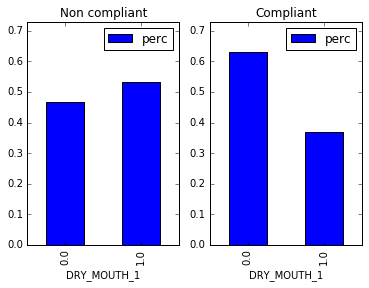

CONG_NASAL_1
   LABEL  CONG_NASAL_1  count  perc
0  0     0.000          15    1.000
1  1     0.000          26    0.963
2  1     1.000          1     0.037
0.0910569105691 0.762837788253 ['no']
[ 0.55555556] [ 0.45605654] ['no']


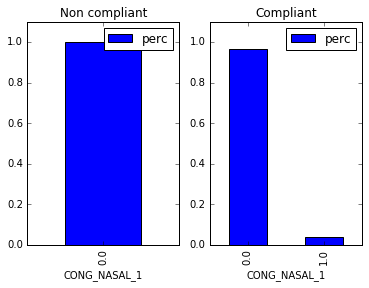

RUNNY_NOSE_1
   LABEL  RUNNY_NOSE_1  count  perc
0  0     0.000          15    1.000
1  1     0.000          26    0.963
2  1     1.000          1     0.037
0.0910569105691 0.762837788253 ['no']
[ 0.55555556] [ 0.45605654] ['no']


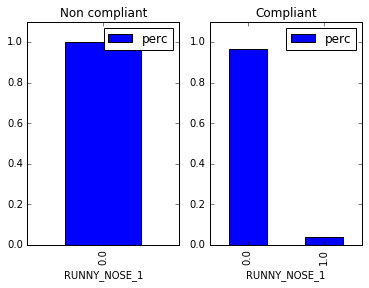

SNEEZING_1
   LABEL  SNEEZING_1  count  perc
0  0     0.000        15    1.000
1  1     0.000        26    0.963
2  1     1.000        1     0.037
0.0910569105691 0.762837788253 ['no']
[ 0.55555556] [ 0.45605654] ['no']


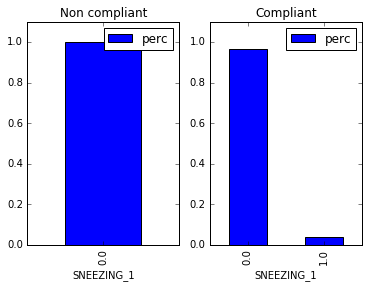

SINUSITIS_1
   LABEL  SINUSITIS_1  count  perc
0  0     0.000         15    1.000
1  1     0.000         27    1.000
0.0 1.0 ['no']
[ nan] [ nan] ['no']


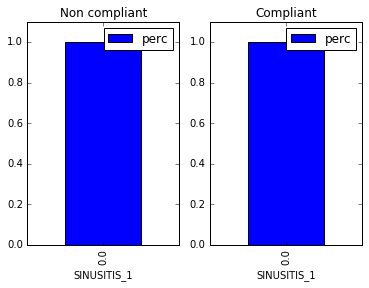

NOSEBLEED_1
   LABEL  NOSEBLEED_1  count  perc
0  0     0.000         15    1.000
1  1     0.000         27    1.000
0.0 1.0 ['no']
[ nan] [ nan] ['no']


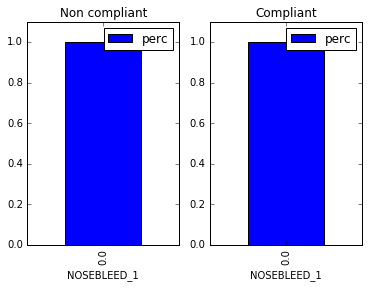

DISCOMFORT_1
   LABEL  DISCOMFORT_1  count  perc
0  0     0.000          15    1.000
1  1     0.000          27    1.000
0.0 1.0 ['no']
[ nan] [ nan] ['no']


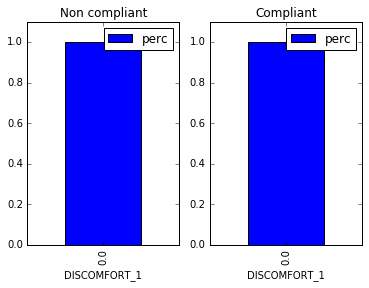

In [553]:
from scipy.stats import chisquare

for i in range(len(catCols)):
    if catCols[i] == 1:
                
        gr = dfImputed.groupby(["LABEL",dfImputed.columns[i]]).count().iloc[:,:1].reset_index()
        gr["count"] = gr.iloc[:,2]
        gr["perc"] = 0.0
        for j in range(gr.shape[0]):
            if gr["LABEL"].iloc[j] == 0:
                gr.set_value(j,"perc", gr.iloc[j]["count"]/float(gr[gr["LABEL"] == 0]["count"].sum()))
            else:
                gr.set_value(j,"perc", gr.iloc[j]["count"]/float(gr[gr["LABEL"] == 1]["count"].sum()))

        #Significance tests
        r1, p1 = chi2(dfImputed.iloc[:,i].values.astype(int).reshape(-1,1),dfImputed["LABEL"].values.astype(int).reshape(-1,1))        
        r,p,df,kounts = chi_square_of_df_cols(dfImputed, dfImputed.columns[i], 'LABEL')
        
        #if p < 0.05 or p1 < 0.05:
            
        sigArr.append([dfImputed.columns[i], p, p1[0], "cat"])
        print dfImputed.columns[i]        
        print gr.loc[:,["LABEL", dfImputed.columns[i], "count","perc"]]            
        print r, p, ["yes" if p < 0.05 else "no"]
        print r1, p1, ["yes" if p1 < 0.05 else "no"]

        ax = plt.subplot(1,2,1)
        gr[gr.LABEL == 0].loc[:,[dfImputed.columns[i], "perc"]].plot(ax=ax,kind="bar",x=dfImputed.columns[i],y="perc")

        ax.set_ylim(0,np.nanmax(gr["perc"])[0]+.1)
        ax.set_title("Non compliant")
        ax = plt.subplot(1,2,2)
        gr[gr.LABEL == 1].loc[:,[dfImputed.columns[i], "perc"]].plot(ax=ax,kind="bar",x=dfImputed.columns[i],y="perc")
        ax.set_ylim(0,np.nanmax(gr["perc"])[0]+.1)
        ax.set_title("Compliant")
        plt.show()

#### Numerical data

AGE
   LABEL   mean    std    max    min  count
0 0.000  51.467 12.705 71.000 33.000 15.000
1 1.000  59.963 11.650 81.000 40.000 27.000
[ 1687.54068488] [ 0.] ['yes']
[ 41.07968701] [ 0.] ['yes']
0.0 4.32526922354e-16 ['yes']


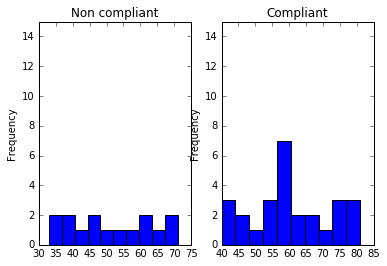

SMOKE_PACK_YEAR
   LABEL    mean     std       max   min  count
0 0.000  139.667 228.694 730.000   0.000 15.000
1 1.000  159.704 269.319 1,095.000 0.000 27.000
[ 14.96710328] [ 0.00021848] ['yes']
[ 3.86873407] [ 0.00021848] ['yes']
793.5 0.199856359845 ['no']


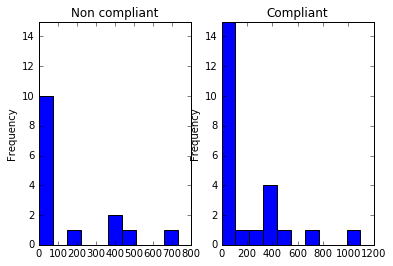

SMOKE_EX_YEAR
   LABEL  mean   std    max   min  count
0 0.000  0.733 2.086 8.000  0.000 15.000
1 1.000  3.787 6.525 20.000 0.000 27.000
[ 0.0648089] [ 0.79968801] ['no']
[-0.25457591] [ 0.79968801] ['no']
682.5 0.0248686589155 ['yes']


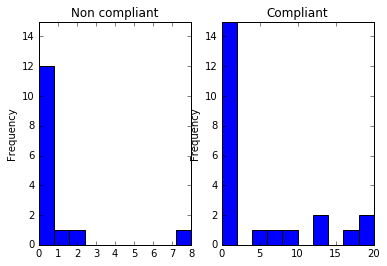

ALCOHOL_GR_DAY
   LABEL  mean    std    max   min  count
0 0.000  4.333 10.499 40.000 0.000 15.000
1 1.000  4.354 8.694  40.000 0.000 27.000
[ 0.48423456] [ 0.48847808] ['no']
[ 0.69586964] [ 0.48847808] ['no']
759.0 0.117314849469 ['no']


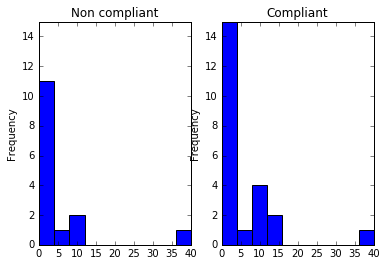

CAFES_DAY
   LABEL  mean   std   max   min  count
0 0.000  1.667 1.345 5.000 0.000 15.000
1 1.000  1.185 1.265 4.500 0.000 27.000
[ 0.27794834] [ 0.59947261] ['no']
[ 0.52720806] [ 0.59947261] ['no']
726.0 0.0736777645431 ['no']


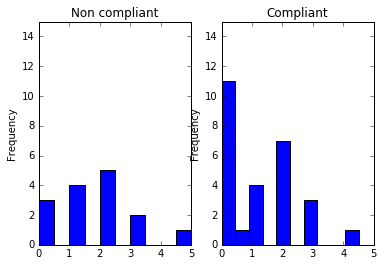

SLEEP_TIME
   LABEL    mean    std     max     min  count
0 0.000  391.917 75.338 499.000 238.000 15.000
1 1.000  388.556 74.005 500.000 173.000 27.000
[ 4194.77112007] [ 0.] ['yes']
[ 64.76705274] [ 0.] ['yes']
0.0 4.355301361e-16 ['yes']


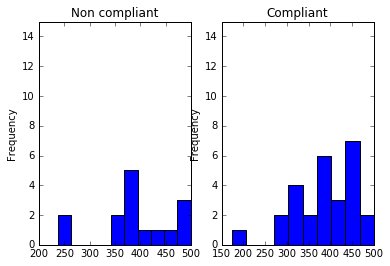

IAH
   LABEL   mean    std    max    min  count
0 0.000  46.609 18.965 79.070 15.500 15.000
1 1.000  56.754 21.484 94.500 22.900 27.000
[ 1089.29537087] [ 0.] ['yes']
[ 33.00447501] [ 0.] ['yes']
0.0 4.35831532601e-16 ['yes']


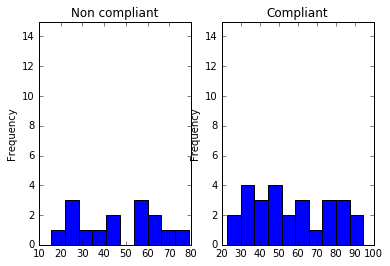

TIME_SAT<90%
   LABEL   mean    std     max   min  count
0 0.000  56.565 83.999 299.200 1.970 15.000
1 1.000  70.157 71.691 282.500 0.900 27.000
[ 188.26793079] [ 0.] ['yes']
[ 13.72107615] [ 0.] ['yes']
27.0 3.14936988134e-15 ['yes']


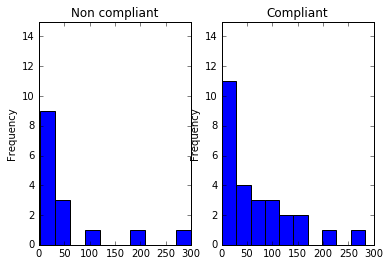

IND_DESAT
   LABEL   mean    std    max   min  count
0 0.000  36.229 21.290 72.200 6.380 15.000
1 1.000  41.045 27.670 90.700 1.970 27.000
[ 313.26376506] [ 0.] ['yes']
[ 17.69925888] [ 0.] ['yes']
0.0 4.35680809864e-16 ['yes']


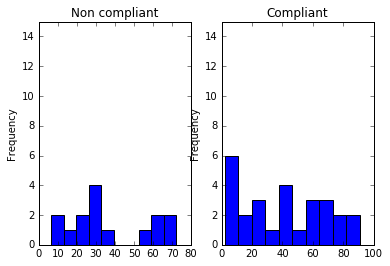

SIZE
   LABEL  mean   std   max   min  count
0 0.000  1.657 0.109 1.920 1.500 15.000
1 1.000  1.675 0.095 1.830 1.500 27.000
[ 20.27558395] [ 0.00002198] ['yes']
[ 4.50284176] [ 0.00002198] ['yes']
783.0 0.184339347156 ['no']


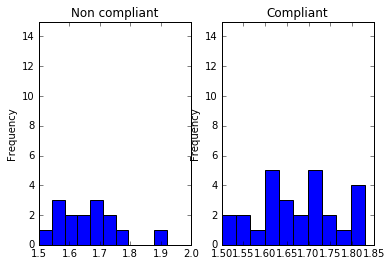

BMI
   LABEL   mean   std    max    min  count
0 0.000  33.150 8.163 50.220 23.330 15.000
1 1.000  34.214 5.438 44.780 23.390 27.000
[ 1307.36412262] [ 0.] ['yes']
[ 36.15749055] [ 0.] ['yes']
0.0 4.35680809864e-16 ['yes']


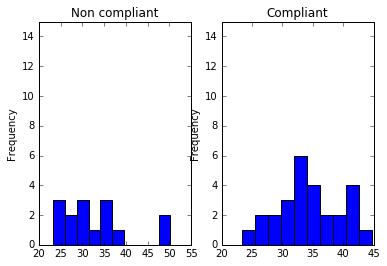

CIRC_NECK
   LABEL   mean   std    max    min  count
0 0.000  43.067 5.216 53.000 35.000 15.000
1 1.000  42.222 3.776 50.000 35.000 27.000
[ 1675.63906758] [ 0.] ['yes']
[ 40.93457057] [ 0.] ['yes']
0.0 4.19251643379e-16 ['yes']


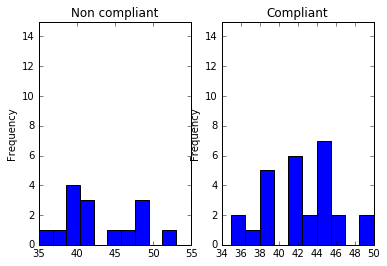

TAS_MEAN
   LABEL    mean    std     max     min  count
0 0.000  129.733 16.662 167.000 106.000 15.000
1 1.000  141.981 21.572 192.000 93.500  27.000
[ 2984.00196852] [ 0.] ['yes']
[ 54.62601915] [ 0.] ['yes']
0.0 4.3492793048e-16 ['yes']


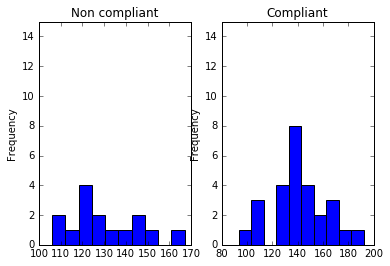

TAD_MEAN
   LABEL   mean    std     max    min  count
0 0.000  84.600 10.105 104.500 65.000 15.000
1 1.000  88.333 17.143 127.500 59.000 27.000
[ 2328.97851711] [ 0.] ['yes']
[ 48.25949147] [ 0.] ['yes']
0.0 4.34026088724e-16 ['yes']


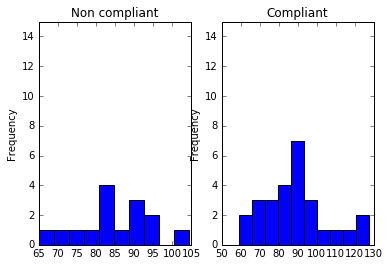

SAT_O2
   LABEL   mean   std    max    min  count
0 0.000  97.933 0.704 99.000 96.000 15.000
1 1.000  97.148 1.769 99.000 93.000 27.000
[ 2778.24041475] [ 0.] ['yes']
[ 52.70901645] [ 0.] ['yes']
0.0 2.06115961466e-16 ['yes']


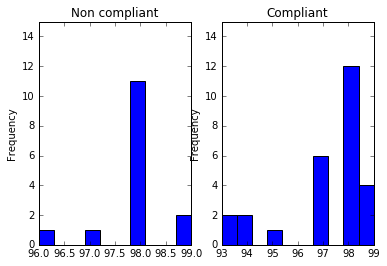

PRESS_CPAP
   LABEL   mean   std    max   min  count
0 0.000  10.760 1.233 13.000 8.000 15.000
1 1.000  11.015 1.153 14.000 9.000 27.000
[ 574.56990056] [ 0.] ['yes']
[ 23.97018775] [ 0.] ['yes']
0.0 3.3005819816e-16 ['yes']


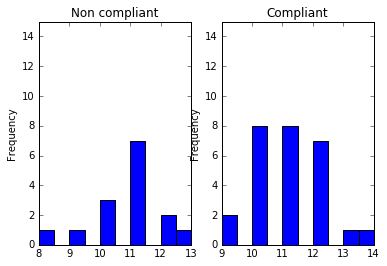

EPWORTH
   LABEL  mean   std    max   min  count
0 0.000  9.267 4.448 17.000 2.000 15.000
1 1.000  8.607 4.908 18.000 0.000 27.000
[ 144.48677922] [ 0.] ['yes']
[ 12.02026536] [ 0.] ['yes']
61.5 3.42067658337e-14 ['yes']


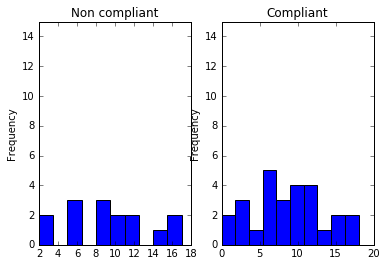

EUROQOL
   LABEL  mean   std   max   min  count
0 0.000  0.796 0.236 1.000 0.130 15.000
1 1.000  0.782 0.216 1.000 0.374 27.000
[ 0.82221981] [ 0.36718888] ['no']
[-0.90676337] [ 0.36718888] ['no']
630.0 0.0105804702212 ['yes']


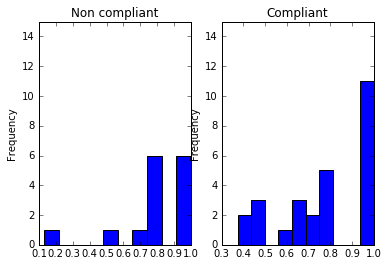

VISUAL
   LABEL   mean    std     max    min  count
0 0.000  64.000 18.146 90.000  40.000 15.000
1 1.000  54.852 25.665 100.000 5.000  27.000
[ 812.44457106] [ 0.] ['yes']
[ 28.50341332] [ 0.] ['yes']
0.0 3.63094837081e-16 ['yes']


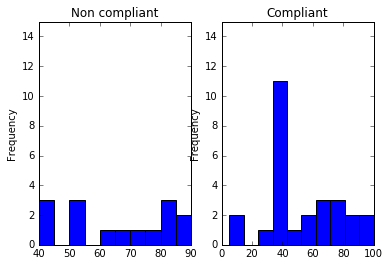

TOTAL_USE_HOURS_1
   LABEL    mean    std     max    min  count
0 0.000  182.804 86.338 318.000 10.000 15.000
1 1.000  237.062 96.429 451.000 98.000 27.000
[ 1367.28390716] [ 0.] ['yes']
[ 36.97680228] [ 0.] ['yes']
0.0 4.34026088724e-16 ['yes']


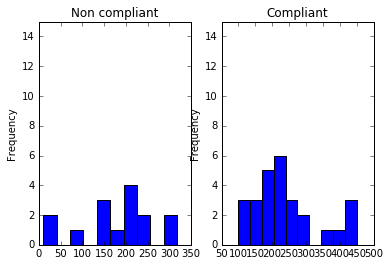

MEAN_USE_HOURS_1
   LABEL  mean   std   max   min  count
0 0.000  4.608 1.608 7.000 0.200 15.000
1 1.000  5.901 1.514 8.500 3.000 27.000
[ 162.33488985] [ 0.] ['yes']
[ 12.74107099] [ 0.] ['yes']
27.0 2.99715253084e-15 ['yes']


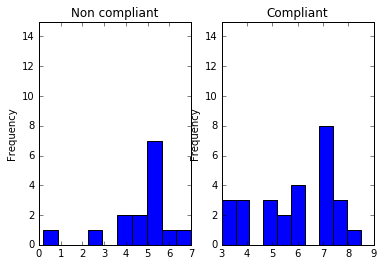

TAS_MEAN_1
   LABEL    mean    std     max     min  count
0 0.000  129.541 16.205 167.000 105.500 15.000
1 1.000  134.984 19.254 183.500 94.000  27.000
[ 2983.23179377] [ 0.] ['yes']
[ 54.61896918] [ 0.] ['yes']
0.0 4.32526922354e-16 ['yes']


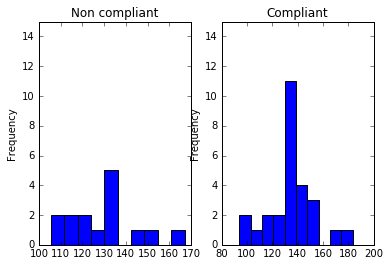

TAD_MEAN_1
   LABEL   mean    std     max    min  count
0 0.000  81.689 8.001  94.500  65.000 15.000
1 1.000  82.866 13.517 115.000 49.500 27.000
[ 2322.08705367] [ 0.] ['yes']
[ 48.18803849] [ 0.] ['yes']
0.0 4.25840680525e-16 ['yes']


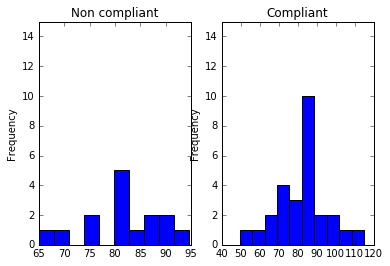

EPWORTH_1
   LABEL  mean   std    max   min  count
0 0.000  7.080 3.322 15.000 2.000 15.000
1 1.000  5.506 3.561 14.000 0.000 27.000
[ 101.53454287] [ 0.] ['yes']
[ 10.07643503] [ 0.] ['yes']
88.5 2.18992123257e-13 ['yes']


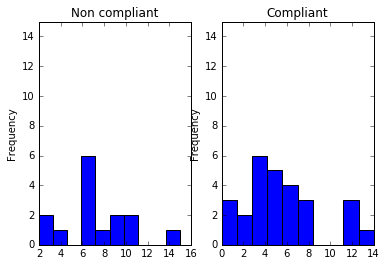

EUROQOL_1
   LABEL  mean   std   max   min  count
0 0.000  0.873 0.114 1.000 0.701 15.000
1 1.000  0.832 0.146 1.000 0.493 27.000
[ 0.17910357] [ 0.67325266] ['no']
[-0.4232063] [ 0.67325266] ['no']
630.0 0.0106401996528 ['yes']


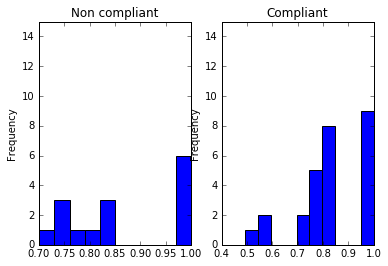

VISUAL_EUROQOL_1
   LABEL   mean    std     max    min  count
0 0.000  74.523 13.150 90.000  40.000 15.000
1 1.000  68.959 18.680 100.000 20.000 27.000
[ 1698.95178055] [ 0.] ['yes']
[ 41.21834277] [ 0.] ['yes']
0.0 3.94801890322e-16 ['yes']


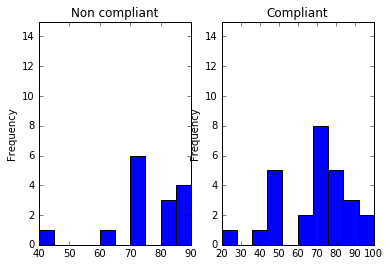

In [554]:
from scipy import stats

for i in range(len(catCols)):
    if catCols[i] == 0:

        r, p = f_oneway(np.log((dfImputed.iloc[:,i].values.astype(float)+1.0).reshape(-1,1)),dfImputed["LABEL"].values.astype(int).reshape(-1,1))
        r1, p1 = stats.ttest_ind(np.log(dfImputed.iloc[:,i].values.astype(float) + 1.0).reshape(-1,1), dfImputed["LABEL"].values.astype(int).reshape(-1,1))
        r2, p2 = stats.mannwhitneyu(np.log(dfImputed.iloc[:,i].values.astype(float) + 1.0).reshape(-1,1), dfImputed["LABEL"].values.astype(int).reshape(-1,1))
           
        #if p < 0.05 or p1 < 0.05:
                    
        gr = dfImputed[["LABEL",dfImputed.columns[i]]].groupby(["LABEL"]).agg({"std","mean","count","min","max"}).iloc[:,:6].reset_index()
        gr = pd.DataFrame(gr.values, columns=["LABEL","std","count","max","min","mean"])

        sigArr.append([dfImputed.columns[i], p1[0], p2, "num"])

        print dfImputed.columns[i]        
        print gr.loc[:,["LABEL","mean","std","max","min","count"]]
        print r, p, ["yes" if p < 0.05 else "no"]
        print r1, p1, ["yes" if p1 < 0.05 else "no"]            
        print r2, p2, ["yes" if p2 < 0.05 else "no"]

        ax = plt.subplot(1,2,1)
        dfImputed[dfImputed.LABEL == 0][dfImputed.columns[i]].plot(ax=ax,kind="hist")#,x=dfImputed.columns[i],y="mean")
        ax.set_ylim(0,15)
        ax.set_title("Non compliant")
        ax = plt.subplot(1,2,2)
        dfImputed[dfImputed.LABEL == 1][dfImputed.columns[i]].plot(ax=ax,kind="hist")#,x=dfImputed.columns[i],y="mean")
        ax.set_ylim(0,15)
        ax.set_title("Compliant")
        plt.show()

In [555]:
print len(sigArr)
dfSigArr = pd.DataFrame(sigArr, columns=["column","pval","pval1","type"])
#dfSigArr = dfSigArr[dfSigArr.column.str.contains("_1")]
dfSigArr

70


,column,pval,pval1,type
0,GENDER,0.921,0.890,cat
1,ACTIVE,0.779,0.698,cat
2,RETIRED,0.733,0.577,cat
3,SMOKER,0.887,0.881,cat
4,ALCOHOL,0.546,0.482,cat
5,DEPRESSION,0.388,0.237,cat
6,ANXIETY,0.823,0.585,cat
7,HTA,0.024,0.101,cat
8,CARDIOPATHY,0.575,0.439,cat
9,RESP_DIS,0.754,0.559,cat


### Clean features (optional)

In [478]:
df_all = df_all[df_all.columns[~df_all.columns.isin(to_del)]]
catCols = catCols[~dfImputed.columns[:-1].isin(to_del)]
dfImputed = dfImputed[dfImputed.columns[:-1][~dfImputed.columns[:-1].isin(to_del)]]
columns = df_all.columns


print len(to_del)
print df_all.shape
print dfImputed.shape
print columns.shape
print len(catCols)

7
(42, 64)
(42, 63)
(64,)
63


### SAVE filtered data

In [479]:
print index

if index == 0:
    fileName = os.path.join('resources','data_filtered_cl0_short_no_monit_14012016_final.pkl')
    fileName1 = os.path.join('resources','mapping_filtered_cl0_short_no_monit_14012016_final.pkl')
elif index == 1:
    fileName = os.path.join('resources','data_filtered_cl0_short_1m_monit_14012016_final.pkl')
    fileName1 = os.path.join('resources','mapping_filtered_cl0_short_1m_monit_14012016_final.pkl')
else:
    fileName = os.path.join('resources','data_filtered_cl0_short_3m_1m_monit_14012016_final.pkl')
    fileName1 = os.path.join('resources','mapping_filtered_cl0_short_3m_1m_monit_14012016_final.pkl')

df_all_codes = df_all.copy()
df_all_codes.insert(0,"CODIGO", codes)
df_all_codes.to_pickle(fileName)
print df_all.shape

#save feature mapping 
dfFeatures.to_pickle(fileName1)
print dfFeatures.shape

1
(42, 64)
(93, 6)


#### Post processing data description

In [480]:
print len(df_all.columns[catCols==1]), df_all.columns[catCols==1]

dfCat_1 = dfCatSum[dfCatSum.variable.isin(df_all.columns[catCols==1])]
dfCat_2 = dfSigArr[dfSigArr.column.isin(df_all.columns[catCols==1])]
dfCatFinal = pd.merge(dfCat_1, dfCat_2,left_on="variable", right_on="column")
dfCatFinal["sig."] = dfCatFinal.pval < 0.05
types = []
for n in dfCatFinal.variable:
    c = dfFeatures[dfFeatures["Name"] == n].Cat.values[0]
    types.append(c)
    
dfCatFinal["type"] = types

pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfCatFinal[["variable", "type","categories", "frequencies","ratios", "pval","sig."]].to_html(index=False)))

37 Index([u'GENDER', u'ACTIVE', u'RETIRED', u'SMOKER', u'ALCOHOL', u'DEPRESSION',
       u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS', u'DIABETES',
       u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'AL_IRR_CUT_MASC_1', u'DRY_MOUTH_1'],
      dtype='object')


variable,type,categories,frequencies,ratios,pval,sig.
DRY_MOUTH_1,SYMPTOMS,"[0.0, 1.0]","[24, 18]","[0.57, 0.43]",0.486,False
AL_IRR_CUT_MASC_1,SYMPTOMS,"[0.0, 1.0]","[34, 8]","[0.81, 0.19]",0.598,False


In [481]:
print len(df_all.columns[catCols==0]), df_all.columns[catCols==0]

dfNum_1 = dfImputed[dfImputed.columns[catCols==0]].describe().T
dfNum_1["variable"] = dfNum_1.index

dfNum_2 = dfSigArr[dfSigArr.column.isin(df_all.columns[catCols==0])]
dfNumFinal = pd.merge(dfNum_1, dfNum_2, left_on="variable", right_on="column")
dfNumFinal["sig."] = dfNumFinal.pval1 < 0.05

types = []
for n in dfNumFinal.variable:
    c = dfFeatures[dfFeatures["Name"] == n].Cat.values[0]
    types.append(c)
    
dfNumFinal["type"] = types
dfNumFinal = dfNumFinal[dfNumFinal.variable.str.contains("_1")]
pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfNumFinal[["variable","type","mean","std","max","25%","50%","75%","pval1","sig."]].to_html(index=False)))

26 Index([u'AGE', u'SMOKE_PACK_YEAR', u'SMOKE_EX_YEAR', u'ALCOHOL_GR_DAY',
       u'CAFES_DAY', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%', u'IND_DESAT',
       u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN', u'SAT_O2',
       u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL', u'TOTAL_USE_HOURS_1',
       u'MEAN_USE_HOURS_1', u'TAS_MEAN_1', u'TAD_MEAN_1', u'EPWORTH_1',
       u'EUROQOL_1', u'VISUAL_EUROQOL_1'],
      dtype='object')


variable,type,mean,std,max,25%,50%,75%,pval1,sig.
TOTAL_USE_HOURS_1,CPAP_DEVICE,217.684,95.574,451.000,160.750,217.684,251.000,0.000,True
MEAN_USE_HOURS_1,CPAP_DEVICE,5.439,1.652,8.500,4.500,5.439,7.000,0.000,True
TAS_MEAN_1,VISIT_1,133.041,18.214,183.500,122.375,133.041,140.250,0.000,True
TAD_MEAN_1,VISIT_1,82.446,11.749,115.000,75.500,82.446,88.000,0.000,True
EPWORTH_1,VISIT_1,6.068,3.520,15.000,4.000,6.000,7.750,0.000,True
EUROQOL_1,VISIT_1,0.847,0.135,1.000,0.790,0.799,1.000,0.673,False
VISUAL_EUROQOL_1,VISIT_1,70.946,16.959,100.000,62.500,70.946,80.000,0.000,True


### 2. Multinomial exploration

#### PCA visualisation

In [482]:
scaler = preprocessing.StandardScaler().fit(dfImputed)
df_all_scaled = scaler.transform(dfImputed)
df_all_scaled = pd.DataFrame(
    data = np.hstack((df_all_scaled, df_all.iloc[:,-1].reshape(-1,1))), 
    columns = columns)
print df_all_scaled.shape
print df_all_scaled.columns

(42, 64)
Index([u'GENDER', u'ACTIVE', u'RETIRED', u'AGE', u'SMOKER', u'SMOKE_PACK_YEAR',
       u'SMOKE_EX_YEAR', u'ALCOHOL', u'ALCOHOL_GR_DAY', u'CAFES_DAY',
       u'DEPRESSION', u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS',
       u'DIABETES', u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%',
       u'IND_DESAT', u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN',
       u'SAT_O2', u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL',
       u'TOTAL_USE_HOURS_1', u'MEAN_USE_HOURS_1', u'AL_IRR_CUT_MASC_1',
       u'DRY_MOUTH_1', u'TAS_MEAN_1', u'TAD_MEAN_1', u'EPWORTH_1',
       u'EUROQOL_1', u'VISUAL_EUROQOL_1

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [483]:
pca = PCA()
X_SCALED = df_all_scaled.ix[:,:-1].values
X_r = pca.fit(X_SCALED).transform(X_SCALED)
print "DATASET: {}M".format(index)
print('explained variance ratio (first components): %s'
      % str(pca.explained_variance_ratio_))
print "explained variance ratio of 2 pcas:", np.sum(pca.explained_variance_ratio_[:2])

DATASET: 1M
explained variance ratio (first components): [ 0.12190951  0.09954528  0.0857567   0.06069266  0.05209656  0.04809533
  0.04485006  0.04409954  0.03846993  0.03723009  0.03397277  0.02903478
  0.0284915   0.02729411  0.02358746  0.02236329  0.02122582  0.01775506
  0.01726992  0.01555275  0.01504787  0.01325073  0.01179612  0.01105635
  0.00973328  0.00941753  0.00825612  0.00694631  0.00690257  0.00644986
  0.00582723  0.00528074  0.00478089  0.00376343  0.00335724  0.002203
  0.00182853  0.00178261  0.00146414  0.00082439  0.00073795  0.        ]
explained variance ratio of 2 pcas: 0.221454788682


/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


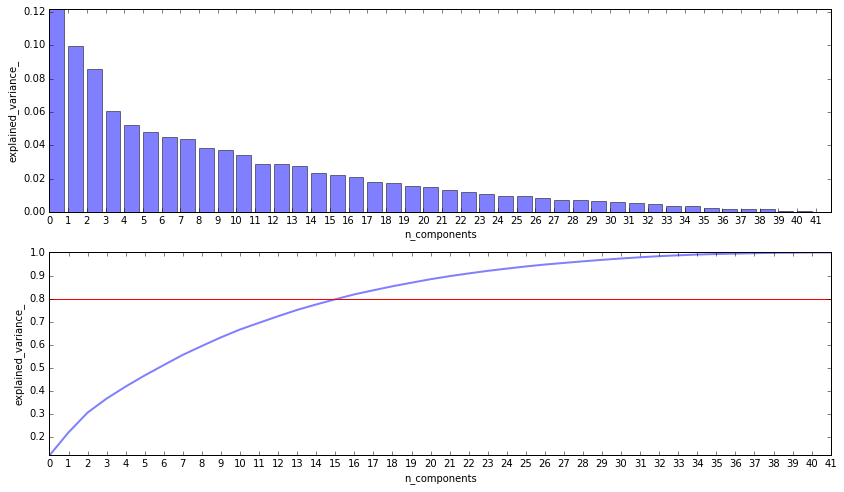

In [484]:
plt.figure(1, figsize=(14, 8))
#plt.clf()
#plt.axes([.2, .2, .7, .7])
ax = plt.subplot(2,1,1)
ax.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, alpha=0.5)#, linewidth=2)
ax.axis('tight')
ax.set_xlabel('n_components')
ax.set_ylabel('explained_variance_')
plt.xticks(range(len(pca.explained_variance_ratio_)),range(len(pca.explained_variance_ratio_)))


#plt.figure(1, figsize=(14, 4))
#plt.clf()
#plt.axes([.2, .2, .7, .7])
ax = plt.subplot(2,1,2)
ax.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), linewidth=2, alpha=0.5)
ax.axhline(0.8,c="r")
ax.axis('tight')
ax.set_xlabel('n_components')
ax.set_ylabel('explained_variance_')
plt.xticks(range(len(pca.explained_variance_ratio_)),range(len(pca.explained_variance_ratio_)))
plt.show()


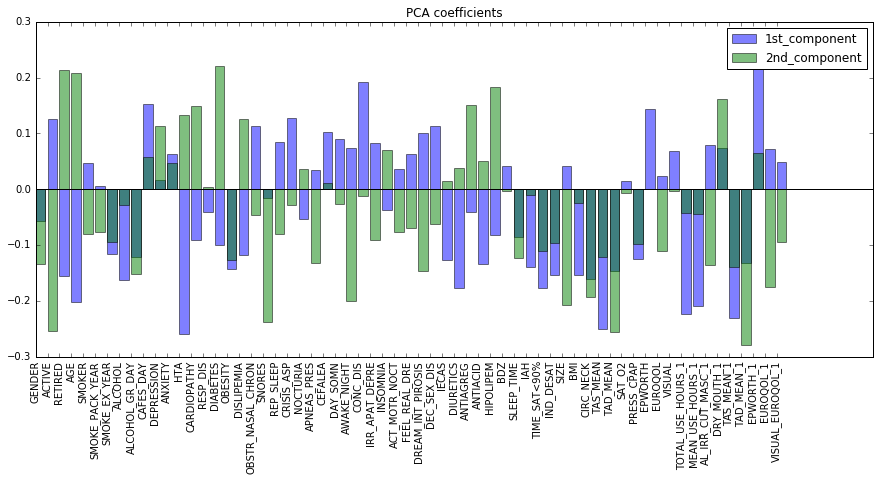

In [485]:
#Plot pca's coefficients
plt.figure(figsize=(15,6))
ax = plt.subplot(1,1,1)
ax.bar(range(pca.components_.shape[1]), pca.components_[0,:],label="1st_component", alpha=0.5)
ax.bar(range(pca.components_.shape[1]), pca.components_[1,:],label="2nd_component", alpha=0.5)
ax.axhline(y=0,c="black")
plt.xticks(range(pca.components_.shape[1]),df_all_scaled.columns,rotation=90)
plt.title("PCA coefficients")
plt.legend()
plt.show()

In [486]:
classes = [0,1]
colors = ["r","g"]


0 Non compliant (<= 3.5) 9 (42, 64) (42, 42)
1 Compliant (> 3.5) 33 (42, 64) (42, 42)

0 Non compliant (<= 3.9) 10 (42, 64) (42, 42)
1 Compliant (> 3.9) 32 (42, 64) (42, 42)

0 Non compliant (<= 4.0) 15 (42, 64) (42, 42)
1 Compliant (> 4.0) 27 (42, 64) (42, 42)

0 Non compliant (<= 4.2) 15 (42, 64) (42, 42)
1 Compliant (> 4.2) 27 (42, 64) (42, 42)

0 Non compliant (<= 4.5) 17 (42, 64) (42, 42)
1 Compliant (> 4.5) 25 (42, 64) (42, 42)

0 Non compliant (<= 5.0) 20 (42, 64) (42, 42)
1 Compliant (> 5.0) 22 (42, 64) (42, 42)


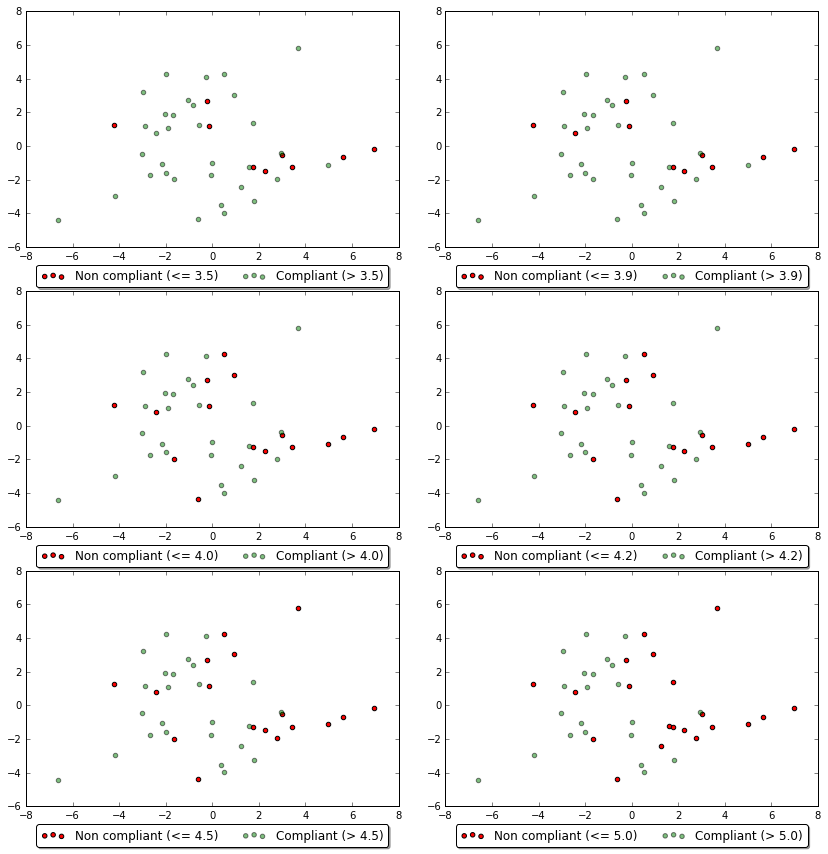

(6, 2)


In [489]:
#Label differences
arr = []
fig = plt.figure(figsize=(12,12))
for t,thr in enumerate(thrs):
    
    target_names = ["Non compliant (<= {})".format(thr), "Compliant (> {})".format(thr)]
    arr.append([np.sum(df_all_scaled.ix[:,-1] <= thr), np.sum(df_all_scaled.ix[:,-1] > thr)])

    for c in classes:
        ax = plt.subplot(round(len(thrs)/2.0),2,t+1)

        if c == 0:
            print "\n",c, target_names[c], np.sum(df_all_scaled.iloc[:,-1].values.astype(float) <= float(thr)), \
                    df_all_scaled.shape, X_r.shape
            
            ax.scatter(X_r[np.where(df_all_scaled.ix[:,-1] <= thr)[0], 0],
                        X_r[np.where(df_all_scaled.ix[:,-1] <= thr)[0], 1], 
                        c=colors[c], label=target_names[c])
        else:
            print c, target_names[c], np.sum(df_all_scaled.iloc[:,-1].values.astype(float) > float(thr)), \
                    df_all_scaled.shape, X_r.shape        
            
            ax.scatter(X_r[np.where(df_all_scaled.ix[:,-1] > thr)[0], 0],
                        X_r[np.where(df_all_scaled.ix[:,-1] > thr)[0], 1], 
                        c=colors[c], label=target_names[c], alpha=0.5)
        
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=2)
            
plt.tight_layout(pad=2.5)
plt.show()

arr = np.array(arr)
print arr.shape

[33 32 27 27 25 22]


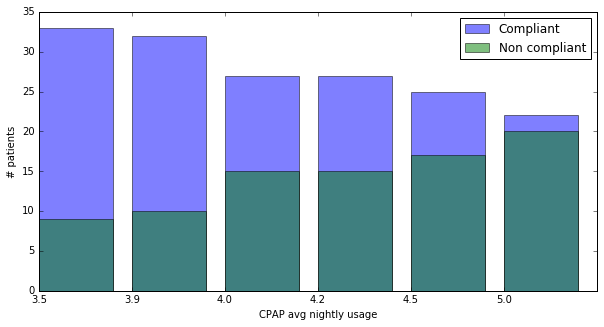

In [498]:
print arr[:,1]

plt.figure(figsize=(10,5))
plt.bar(range(len(arr[:,1])), arr[:,1],label="Compliant", alpha=0.5)
plt.bar(range(len(arr[:,1])), arr[:,0],label="Non compliant", alpha=0.5)

plt.xticks(range(len(thrs)), thrs)
plt.legend()
plt.ylabel("# patients")
plt.xlabel("CPAP avg nightly usage")
plt.show()

#### PCA on numerical data

0 AGE 48.0 57.0 65.0 [ 0.  1.  2.] 12 20 10
1 SMOKE_PACK_YEAR 0.0 0.0 342.25 [ 0.  1.  2.] 23 8 11
2 SMOKE_EX_YEAR 0.0 0.0 1.0 [ 0.  1.  2.] 29 3 10
3 ALCOHOL_GR_DAY 0.0 0.0 5.0 [ 0.  1.  2.] 26 6 10
4 CAFES_DAY 0.0 1.0 2.0 [ 0.  1.  2.] 14 21 7
5 SLEEP_TIME 348.75 392.0 452.25 [ 0.  1.  2.] 11 20 11
6 IAH 37.185 52.945 65.6 [ 0.  1.  2.] 11 20 11
7 TIME_SAT<90% 14.0 31.5 92.4125 [ 0.  1.  2.] 13 18 11
8 IND_DESAT 19.79 34.6 61.3175 [ 0.  1.  2.] 11 20 11
9 SIZE 1.5925 1.665 1.73 [ 0.  1.  2.] 11 21 10
10 BMI 29.6925 33.325 37.05 [ 0.  1.  2.] 11 20 11
11 CIRC_NECK 39.0 42.0 45.0 [ 0.  1.  2.] 12 21 9
12 TAS_MEAN 124.375 137.75 149.375 [ 0.  1.  2.] 11 20 11
13 TAD_MEAN 77.625 86.5 94.875 [ 0.  1.  2.] 11 20 11
14 SAT_O2 97.0 98.0 98.0 [ 0.  1.  2.] 13 23 6
15 PRESS_CPAP 10.0 11.0 12.0 [ 0.  1.  2.] 15 24 3
16 EPWORTH 6.0 9.0 12.0 [ 0.  1.  2.] 15 19 8
17 EUROQOL 0.6839 0.7902 1.0 [ 0.  1.] 12 30 0
18 VISUAL 40.0 55.0 80.0 [ 0.  1.  2.] 17 19 6
19 TOTAL_USE_HOURS_1 160.75 217.684210526

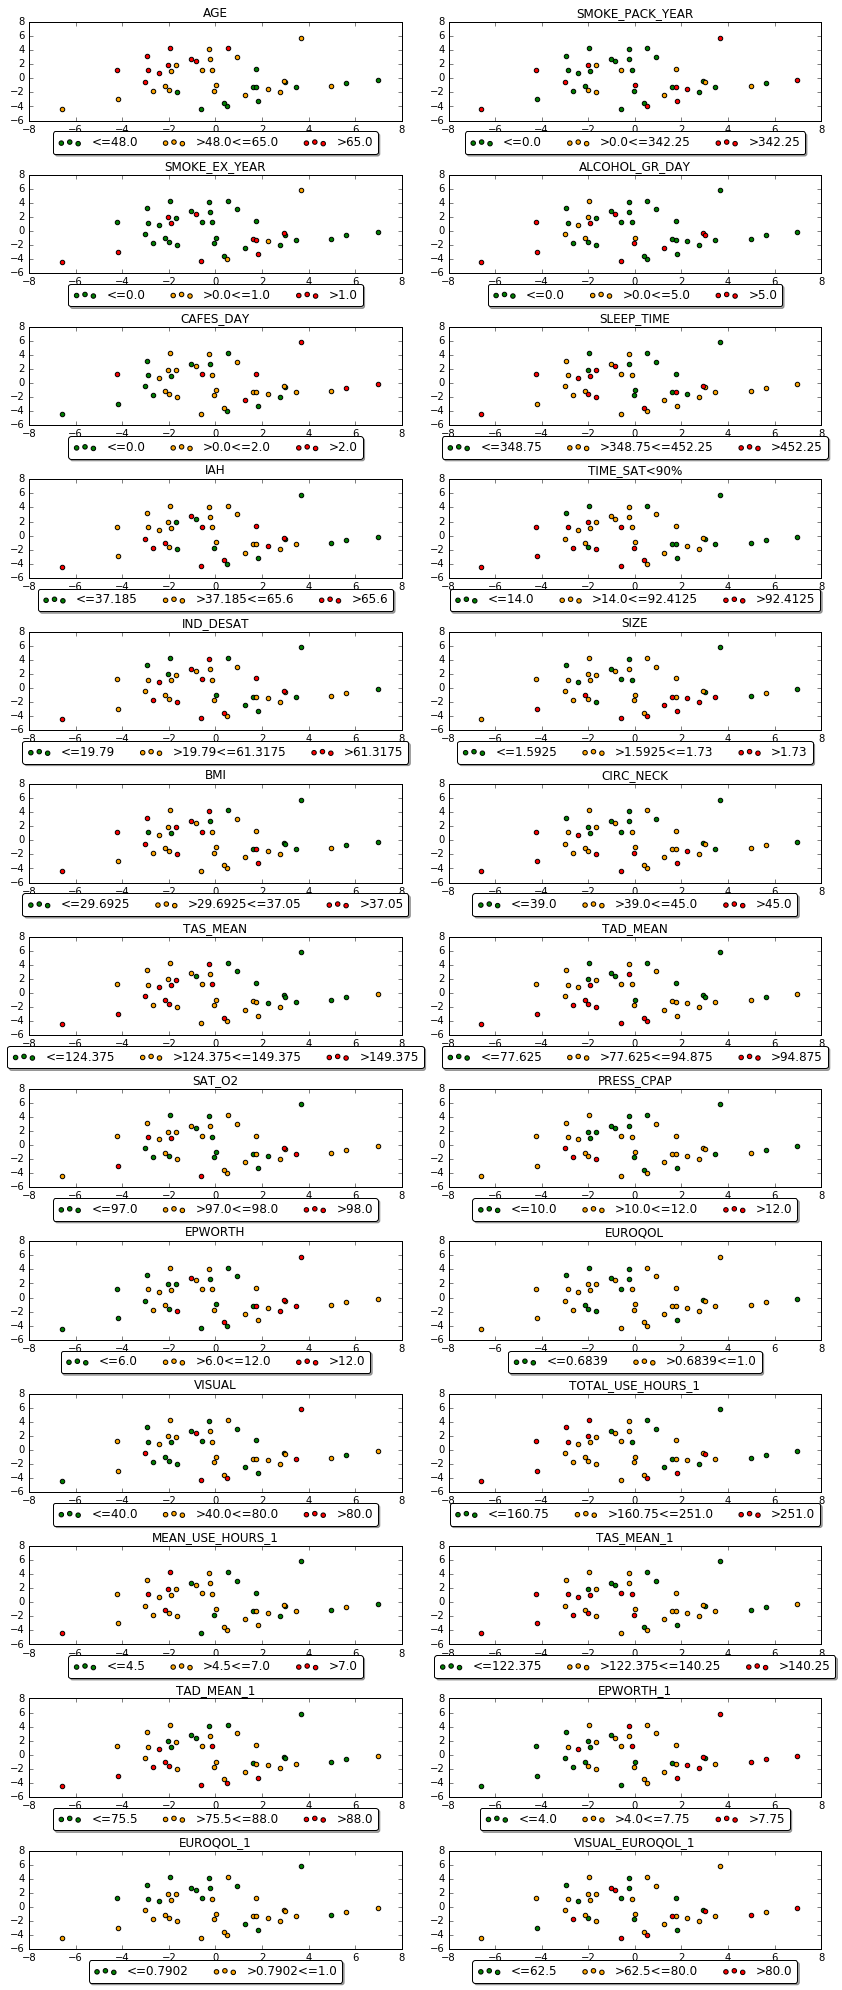

In [495]:
fig = plt.figure(1, figsize=(12, 70))
#plt.grid(visible=False)

k = 0
for i,c in enumerate(df_all_scaled.columns):
        
    if c in dfSigArr[dfSigArr["type"] == "num"]["column"].values: # dfNorm[dfNorm.variable == c][["categoric"]].values == "no":
        val_tmp = dfImputed[c].copy()
        values = dfImputed[c].copy()
        p25 = values.quantile(0.25)
        p50 = values.quantile(0.5)
        p75 = values.quantile(0.75)


        values[val_tmp<=p25] = 0
        values[np.logical_and(val_tmp>p25,val_tmp<=p75)] = 1
        values[val_tmp>p75] = 2
        strLabels = ["<=" + str(p25), ">"+str(p25)+"<="+str(p75), ">" + str(p75)]
        labels = np.unique(values)
        print k, c, p25, p50, p75, labels, np.sum(values==0), np.sum(values==1), np.sum(values==2)
        
        cs = ["green", "orange", "red"]
        ax = plt.subplot(int(len(df_all_scaled.columns)/2)+1,2,k+1)
        for i,l in enumerate(labels):
                ax.scatter(X_r[np.where(values==l)[0], 0], X_r[np.where(values==l)[0], 1], label = strLabels[i], c=cs[i])
        ax.set_title(c)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=3)
        k += 1

        
plt.tight_layout(pad=2.5)
plt.show()

#### Clustering

In [496]:
from sklearn import metrics
from sklearn.cluster import KMeans

pca_dim = 15
best_k_stab = []

for i in range(50):

    best_k = -1
    best_score = -1
    for k in range(2,10,1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100)
        kmeans.fit(X_r[:,:pca_dim])
        X_pred = kmeans.predict(X_r[:,:pca_dim])
        score = metrics.silhouette_score(X_r[:,:2],X_pred,metric='euclidean',sample_size=X_r.shape[0])
        if best_score < score:
            best_score = score
            best_k = k
    print i, best_k, best_score
    best_k_stab.append([best_k, best_score])

0 2 0.397798879979
1 2 0.396171229664
2 2 0.397798879979
3 2 0.397798879979
4 3 0.409389089747
5 2 0.397798879979
6 2 0.397798879979
7 2 0.397798879979
8 2 0.397798879979
9 2 0.397798879979
10 2 0.397798879979
11 2 0.397798879979
12 2 0.397798879979
13 2 0.397798879979
14 2 0.397798879979
15 3 0.409389089747
16 2 0.397798879979
17 2 0.397798879979
18 2 0.397798879979
19 2 0.397798879979
20 2 0.397798879979
21 3 0.409389089747
22 2 0.397798879979
23 2 0.397798879979
24 2 0.397798879979
25 2 0.397798879979
26 2 0.397798879979
27 2 0.397798879979
28 2 0.397798879979
29 2 0.397798879979
30 2 0.397798879979
31 2 0.397798879979
32 2 0.397798879979
33 2 0.397798879979
34 2 0.397798879979
35 2 0.397798879979
36 2 0.397798879979
37 2 0.397798879979
38 2 0.397798879979
39 2 0.397798879979
40 2 0.397798879979
41 2 0.397798879979
42 2 0.397798879979
43 2 0.397798879979
44 2 0.397798879979
45 2 0.397798879979
46 2 0.397798879979
47 2 0.397798879979
48 2 0.383224524135
49 2 0.397798879979


In [497]:
df = pd.DataFrame(best_k_stab, columns = ["k", "score"])
df = df.groupby("k").count().reset_index().iloc[:,:2]
df.sort_values("score", ascending= False, inplace=True)

best_k =  df["k"].iloc[0]
print "Best # clusters:", best_k
df.head()

Best # clusters: 2


,k,score
0,2,47
1,3,3


2


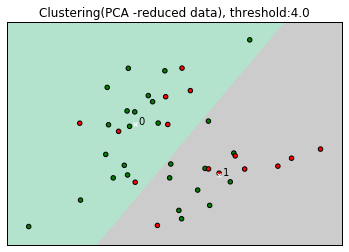

In [499]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_r[:, 0].min() - 1, X_r[:, 0].max() + 1
y_min, y_max = X_r[:, 1].min() - 1, X_r[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model
print best_k

kmeans = KMeans(init='k-means++', n_clusters=best_k, n_init=100)
kmeans.fit(X_r[:,:2])
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Pastel2,
           aspect='auto', origin='lower')


# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=16, linewidths=1,
            color='w', zorder=10, label="")

for k,c in enumerate(range(centroids.shape[0])):
    plt.text(centroids[k,0]+.2, centroids[k,1],str(k))

plt.scatter(X_r[:, 0], X_r[:, 1], c=np.array(["g" if d > thrs[-4] else "r" for d in df_all_scaled.ix[:,-1].values]))
plt.legend()
plt.title('Clustering(PCA -reduced data), threshold:' + str(thrs[-4]))

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

#### K-means explanation

CPAP USAGE (CLUST-0):
[7.0, 7.5, 3.5, 6.5099999999999998, 6.0, 8.0, 3.9300000000000002, 3.5, 7.0, 7.5, 4.0, 6.0, 7.5, 8.0, 7.0, 6.5, 4.5, 5.5, 7.0, 3.7999999999999998, 2.1200000000000001, 7.5, 4.0, 5.5] 5 19 139.36
CPAP USAGE (CLUST-1):
[0.0, 6.5, 5.0, 7.0, 5.0, 4.0, 4.5, 3.3199999999999998, 6.5, 6.5, 0.0, 5.5, 4.9900000000000002, 2.0800000000000001, 5.3200000000000003, 2.6000000000000001, 4.0, 0.96999999999999997] 6 12 73.78


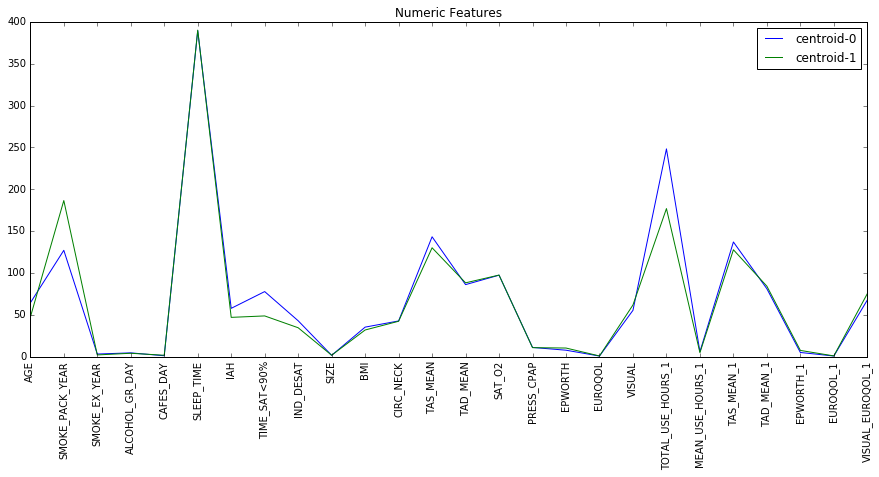

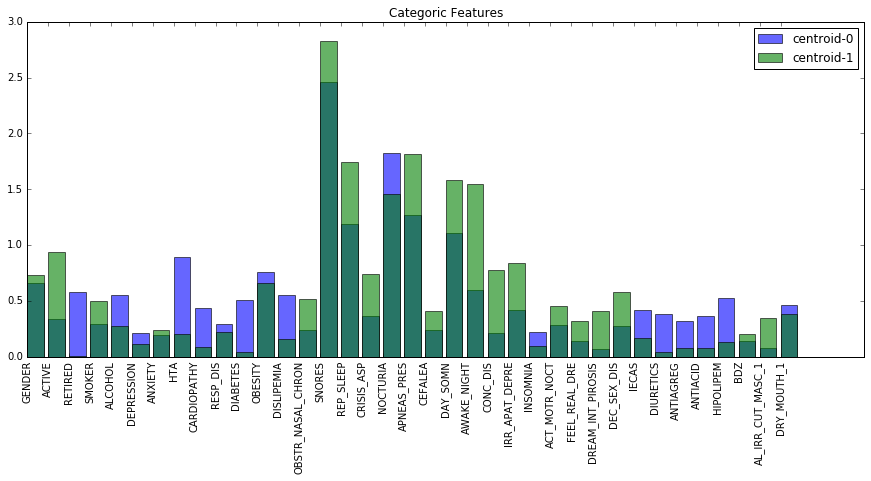

,0,1,diff[0-1]
GENDER,0.661,0.730,-0.070
ACTIVE,0.341,0.935,-0.594
RETIRED,0.578,0.007,0.571
AGE,64.271,47.138,17.133
SMOKER,0.296,0.495,-0.199
SMOKE_PACK_YEAR,127.067,186.521,-59.454
SMOKE_EX_YEAR,3.153,2.087,1.066
ALCOHOL,0.547,0.270,0.277
ALCOHOL_GR_DAY,4.552,4.073,0.479
CAFES_DAY,1.118,1.676,-0.558


In [500]:
X_pred = kmeans.predict(X_r[:,:2])
grAllRedKm = np.hstack((df_all_scaled.iloc[:,:-1],X_pred.reshape(-1,1)))

sleep = [[],[]]
for i,k in enumerate(X_pred):
    sleep[k].append(df_all.iloc[i,-1])
    
print "CPAP USAGE (CLUST-0):\n", sleep[0], np.sum(np.array(sleep[0]) < 4), np.sum(np.array(sleep[0]) >= 4), np.sum(np.array(sleep[0]))
print "CPAP USAGE (CLUST-1):\n", sleep[1], np.sum(np.array(sleep[1]) < 4), np.sum(np.array(sleep[1]) >= 4), np.sum(np.array(sleep[1]))
    
#Get pca for 2 components
pca = PCA(n_components=2)
X_SCALED = df_all_scaled.ix[:,:-1].values
X_r = pca.fit(X_SCALED).transform(X_SCALED)

#Compute centroids
ctrPca = kmeans.cluster_centers_
ctrInvPca = [pca.inverse_transform(ctr.reshape(-1,2)) for ctr in ctrPca]
ctr = [scaler.inverse_transform(ctr) for ctr in ctrInvPca]
dfCtr = pd.DataFrame(np.array(ctr).reshape(2,-1), columns=df_all.columns[:-1])

#Plot categoric features
plt.figure(figsize=(15,6))
ax = plt.subplot(1,1,1)
for i in range(dfCtr.shape[0]):
    ax.plot(range(dfCtr.loc[i,catCols==0].shape[0]), dfCtr.loc[i,catCols==0],label="centroid-"+str(i))

plt.xticks(range(dfCtr.loc[i,catCols==0].shape[0]),dfCtr.columns[catCols==0],rotation=90)
plt.title("Numeric Features")
plt.legend()
plt.show()

#Plot numeric table
plt.figure(figsize=(15,6))
ax = plt.subplot(1,1,1)
for i in range(dfCtr.shape[0]):
    ax.bar(range(dfCtr.loc[i,catCols==1].shape[0]), dfCtr.loc[i,catCols==1],label="centroid-"+str(i),alpha=0.6)

plt.xticks(range(dfCtr.loc[i,catCols==1].shape[0]),dfCtr.columns[catCols==1],rotation=90)
plt.title("Categoric Features")
plt.legend()
plt.show()

#Plot table
diff = (dfCtr.iloc[0,:].values - dfCtr.iloc[1,:].values).reshape(1,-1)
ctr = np.hstack((dfCtr.T.values, diff.T))#, stats.ttest_ind(dfCtr.iloc[:,0], dfCtr.iloc[:,1])[1])
dfCtr = pd.DataFrame(ctr, columns= ["0","1","diff[0-1]"], index = dfCtr.T.index)
dfCtr

#### Outliers analysis

Looking for users with a value in its columns that is an outlier
We need user code!!

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


0.194273612473 9.78505252849 9.97932614097
10.2707365597 9.49364210978

Ouliers min ratio: 10.2707365597 9.49364210978
Num outliers detected: 1
Num outliers detected: 0
[('MY56', 9.9920055220701158), ('MY12', 9.5235831108902662), ('MY45', 9.6690200700082709), ('MY55', 10.59142419659247), ('MY15', 9.959304940917967), ('MY20', 9.8104175679566161), ('MY24', 10.218639867890538), ('MY28', 9.8654927468126221), ('MY51', 9.8161719820955007), ('MY09', 9.5076965250128929), ('MY02', 9.9196491979136319), ('MY59', 9.9732122590772843), ('MY29', 10.109997487730819), ('MY21', 9.982775335202593), ('MY37', 10.071957823715778), ('MY34', 10.090375929733078), ('MY36', 9.7326905977438845), ('MY27', 9.8729964869492779), ('MY44', 9.7772668329049797), ('MY14', 9.968669808076676), ('MY42', 9.7844449191646774), ('MY41', 9.818662012864614), ('MY50', 9.9716982702979138), ('MY18', 9.8322559906353622), ('MY01', 9.8576759229784692), ('MY57', 9.9813641015981176), ('MY46', 9.6534378782104238), ('MY06', 9.78895480275044

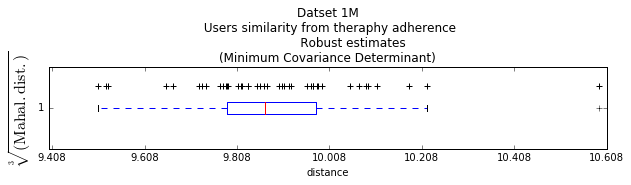

In [501]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet, EllipticEnvelope

dfImputed_out = dfImputed.values
#dfImputed_out = df_all_scaled.ix[:,:-1]
scaler_norm = preprocessing.Normalizer(norm='l2').fit(dfImputed_out[:,:-1])
df_all_norm = scaler_norm.transform(dfImputed_out[:,:-1]).astype(float)

df_all_norm = pd.DataFrame(
    data = np.hstack((df_all_norm, dfImputed_out[:,-1].reshape((dfImputed_out.shape[0],1)))), 
    columns = df_all.columns[:-1])

X_SCALED = df_all_norm.ix[:,:-1].values
#X_SCALED = df_all.ix[:,:-1].values
#X_SCALED = df_all_scaled.ix[:,:-1].values

robust_cov_all = EmpiricalCovariance().fit(X_SCALED[:,:])
robust_mahal_all = robust_cov_all.mahalanobis(X_SCALED[:,:] - robust_cov_all.location_) ** (0.33)

#BoxPlot data
fig = plt.figure(figsize=(10,5))
sf = plt.subplot(3, 1, 1)
bx = sf.boxplot(robust_mahal_all,vert=0)

#ALT:1
#outlierRatioRob_all =  np.min(bx["fliers"][0].get_data()[0])

#ALT:2
rm = pd.DataFrame(robust_mahal_all, columns=["value"])

iqr = float(rm["value"].quantile(0.75)) - float(rm["value"].quantile(0.25))
outlierRatioRob_all_1 = rm["value"].quantile(0.75) + (1.5 * iqr)
outlierRatioRob_all_2 = rm["value"].quantile(0.25) - (1.5 * iqr)
print iqr, rm["value"].quantile(0.25), rm["value"].quantile(0.75)

#threshold = 0.99
#outlierRatioRob_all_1 = rm.quantile(threshold).values[0]
#outlierRatioRob_all_2 = rm.quantile(1-threshold).values[0]

print outlierRatioRob_all_1, outlierRatioRob_all_2
print

sf.plot(robust_mahal_all, 1.26 * np.ones(len(robust_mahal_all)),'+k', markeredgewidth=1)
sf.set_xlabel('distance')
sf.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
sf.set_title("Datset {}M\n Users similarity from theraphy adherence\n \
            Robust estimates\n(Minimum Covariance Determinant)".format(index))
sf.set_xticks(np.arange(min(robust_mahal_all)-0.1, max(robust_mahal_all)+0.1, 0.2))

print "Ouliers min ratio:", outlierRatioRob_all_1, outlierRatioRob_all_2
print "Num outliers detected:", len(X_SCALED[robust_mahal_all > outlierRatioRob_all_1, 0])
print "Num outliers detected:", len(X_SCALED[robust_mahal_all < outlierRatioRob_all_2, 0])
print [(codes[r],robust_mahal_all[r]) for r in range(len(robust_mahal_all))]

patients_out = codes[robust_mahal_all > outlierRatioRob_all_1]
print "Patients outliers above: {}".format(patients_out)

patients_out = codes[robust_mahal_all < outlierRatioRob_all_2]
print "Patients outliers below: {}".format(patients_out)


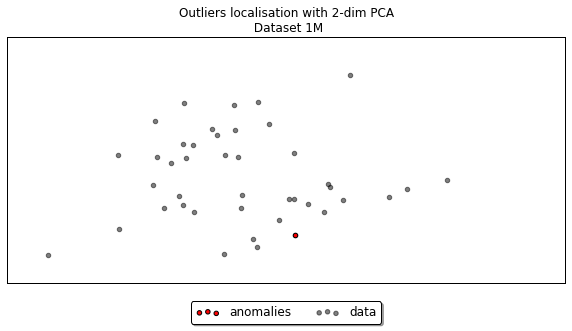

In [503]:
# plot and show data set
fig = plt.figure(figsize=(10,15))
subfig1 = plt.subplot(3, 1, 3)

#Show inliers vs outliers
inlier_plot = subfig1.scatter(X_r[:, 0], X_r[:, 1], c='black', label='inliers', alpha=0.5)
outlier_plot = subfig1.scatter(X_r[robust_mahal_all > outlierRatioRob_all_1, 0], 
                               X_r[robust_mahal_all > outlierRatioRob_all_1, 1],
                               c='red', label='outliers')
outlier_plot = subfig1.scatter(X_r[robust_mahal_all < outlierRatioRob_all_2, 0], 
                               X_r[robust_mahal_all < outlierRatioRob_all_2, 1],
                               c='red', label='outliers')

subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title(("Outliers localisation with 2-dim PCA\n Dataset {}M").format(index))

subfig1.legend([outlier_plot, inlier_plot],\
               ['anomalies','data'],\
               loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.xticks(())
plt.yticks(())

plt.show()

### 3. Visualization

In [504]:
"""
scaler = preprocessing.StandardScaler().fit(dfImputed.ix[:,:-1])
df_all_scaled = scaler.transform(dfImputed.ix[:,:-1])
df_all_scaled = pd.DataFrame(
    data = np.hstack((df_all_scaled, dfImputed.ix[:,-1].values.reshape((dfImputed.shape[0],1)))), 
    columns = dfImputed.columns)

print df_all_scaled.describe()
"""

'\nscaler = preprocessing.StandardScaler().fit(dfImputed.ix[:,:-1])\ndf_all_scaled = scaler.transform(dfImputed.ix[:,:-1])\ndf_all_scaled = pd.DataFrame(\n    data = np.hstack((df_all_scaled, dfImputed.ix[:,-1].values.reshape((dfImputed.shape[0],1)))), \n    columns = dfImputed.columns)\n\nprint df_all_scaled.describe()\n'

#### Visualize all data x columns

(27, 64)
(15, 64)


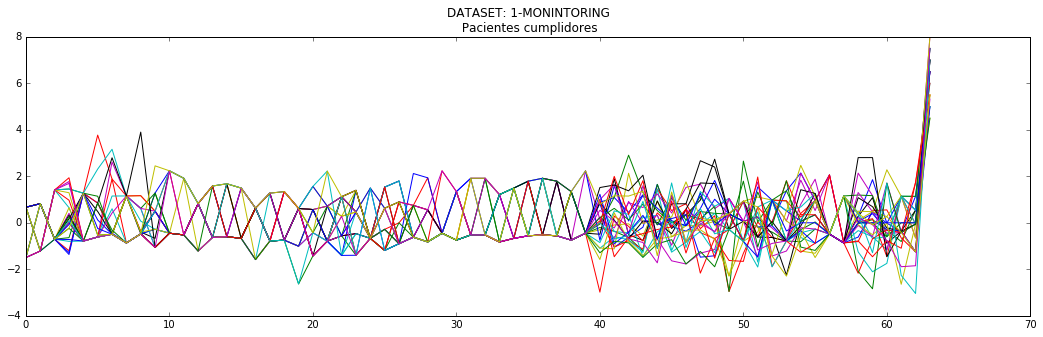

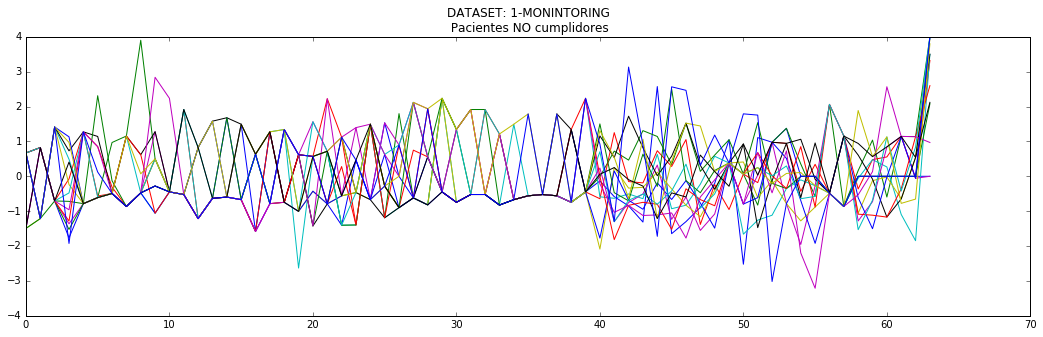

In [505]:
#Visualize row data

data = df_all_scaled[df_all_scaled['LABEL'] > thrs[-4]].values
data = data.astype(float)
print data.shape


plt.figure(figsize=(18,5))
plt.plot(data[:,:].T)
plt.title("DATASET: {}-MONINTORING\n Pacientes cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)

data = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]].values
data = data.astype(float)

print data.shape
plt.figure(figsize=(18,5))
plt.plot(data[:,:].T)
plt.title("DATASET: {}-MONINTORING\n Pacientes NO cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)

#### Visualize mean + std data

(27, 63)


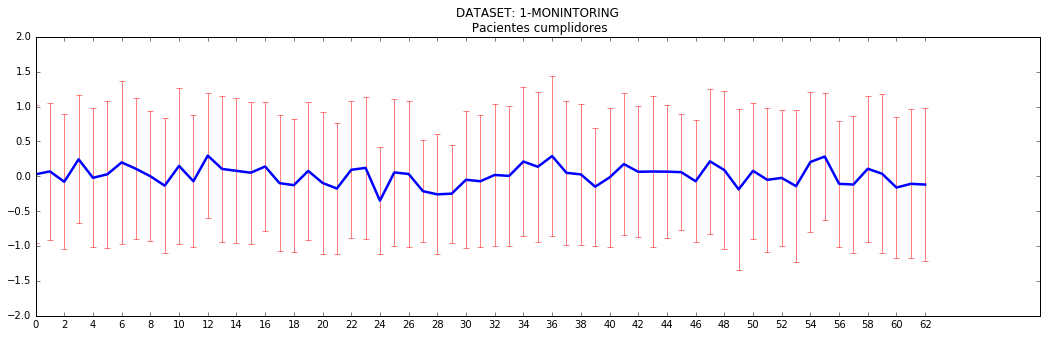

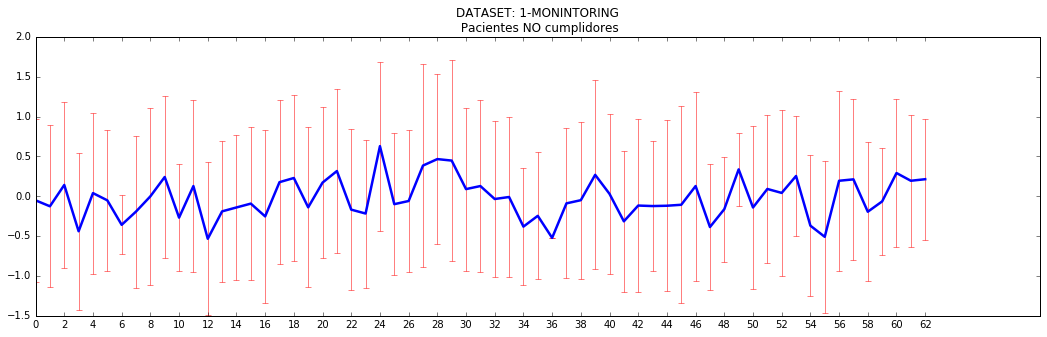

In [506]:
data_tmp = df_all_scaled[df_all_scaled['LABEL']> thrs[-4]].values[:,:-1]
data = data_tmp.astype(float)
print data.shape

plt.figure(figsize=(18,5))
plt.subplot(1,1,1)
plt.errorbar(x=range(data.shape[1]),
             y=np.mean(data, axis=0),
             yerr=np.std(data, axis=0), 
             ecolor='r', capthick=0.5, elinewidth = 0.5, linewidth=2.5
             )
pts = range(data.shape[1])
plt.xticks(np.arange(min(pts), max(pts)+1, 2.0))
plt.title("DATASET: {}-MONINTORING\n Pacientes cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)
plt.ylim((-2,2))

data_tmp = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]].values[:,:-1]
data = data_tmp.astype(float)

plt.figure(figsize=(18,5))
plt.errorbar(x=range(data.shape[1]),
             y=np.mean(data, axis=0),
             yerr=np.std(data, axis=0),
             ecolor='r', capthick=0.5, elinewidth = 0.5, linewidth=2.5
             )
pts = range(data.shape[1])
plt.xticks(np.arange(min(pts), max(pts)+1, 2.0))
plt.title("DATASET: {}-MONINTORING\n Pacientes NO cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)

In [507]:
df_all_scaled[df_all_scaled['LABEL']==0][df_all_scaled.columns[:-1]]

,GENDER,ACTIVE,RETIRED,AGE,SMOKER,SMOKE_PACK_YEAR,SMOKE_EX_YEAR,ALCOHOL,ALCOHOL_GR_DAY,CAFES_DAY,...,VISUAL,TOTAL_USE_HOURS_1,MEAN_USE_HOURS_1,AL_IRR_CUT_MASC_1,DRY_MOUTH_1,TAS_MEAN_1,TAD_MEAN_1,EPWORTH_1,EUROQOL_1,VISUAL_EUROQOL_1
0,0.670,0.825,-0.707,-1.765,-0.784,-0.611,-0.493,-0.866,-0.476,-0.278,...,1.376,0.000,-0.000,-0.485,-0.866,0.000,0.000,0.000,0.000,0.000
15,-1.494,0.825,-0.707,-1.362,-0.784,-0.611,-0.493,-0.866,-0.476,1.280,...,-0.782,-1.956,-0.269,2.062,1.155,-1.280,-0.728,0.843,1.144,-0.056


In [508]:
target_names = ['No compliant', 'Compliant']
classLbls = ['No cumplidor', 'Cumplidor']
classes = [0,1]

(15, 63)
(27, 63)


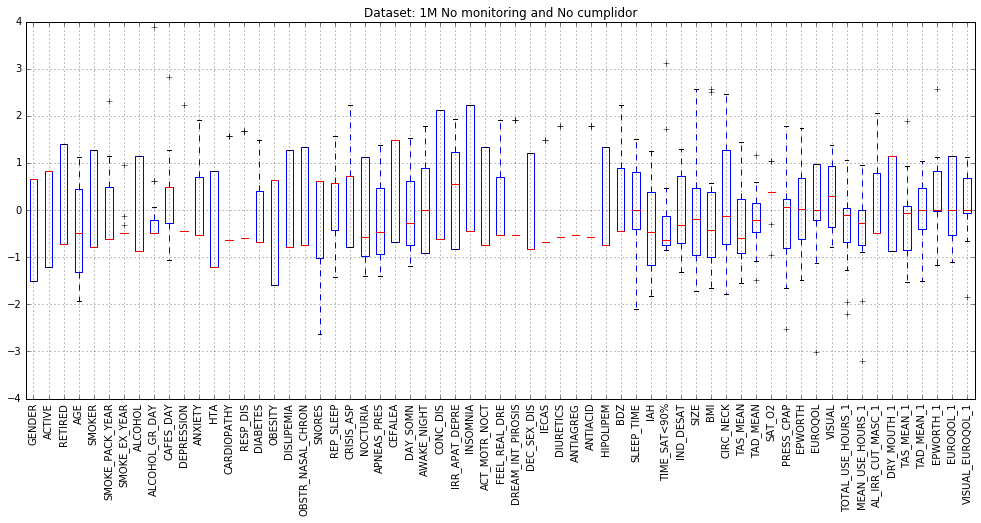

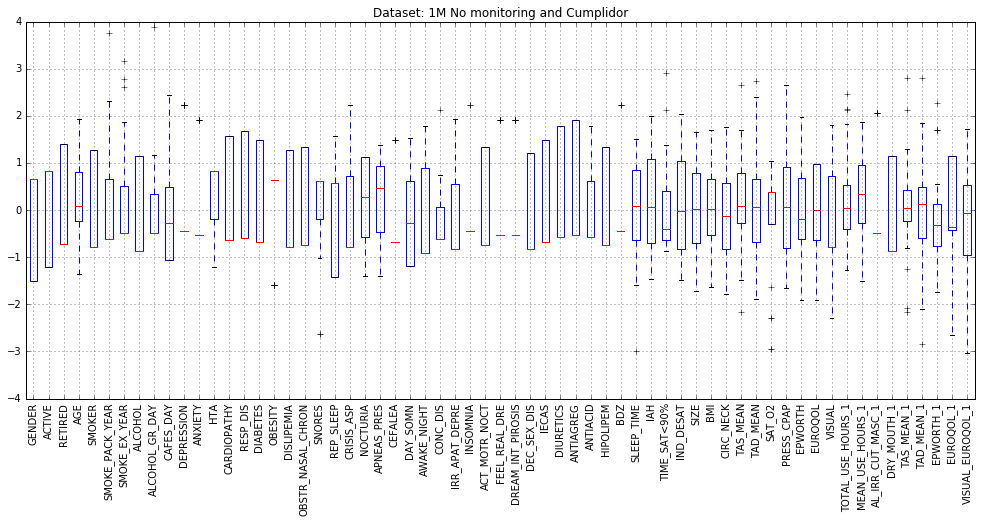

In [520]:
figsize = (17, 6.75)

codes_type = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]].index
df = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]][df_all_scaled.columns[:-1]]
print df.shape
fig, ax = plt.subplots(figsize=figsize)
df.astype(float).boxplot(rot=90)
ax.set_title("Dataset: {}M No monitoring and {}".format(index, classLbls[0]))

codes_type = df_all_scaled[df_all_scaled['LABEL']> thrs[-4]].index
df = df_all_scaled[df_all_scaled['LABEL']> thrs[-4]][df_all_scaled.columns[:-1]]
print df.shape
fig, ax = plt.subplots(figsize=figsize)
df.astype(float).boxplot(rot=90)
ax.set_title("Dataset: {}M No monitoring and {}".format(index, classLbls[1]))